In [1]:
# Our engines
import numpy as np
import scipy.integrate
import scipy.optimize
import pandas as pd
import time
from numba import jit

import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

%config InlineBackend.figure_formats = {'png', 'retina'}

rcrc = {'grid': True,
      'axisbelow': True,
      'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18}
sns.set_context('notebook', rc=rcrc)
sns.set_style('whitegrid', rc=rcrc)

import matplotlib
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

plt.rcParams['text.usetex'] = False

In [2]:
colors = np.array([[   0.5,    0.5,    0.5],   #  1) gray
                   [0.3010, 0.7450, 0.9330],   #  2) cyan
                   [     0, 0.4470, 0.7410],   #  3) blue
                   [     0, 0.2235, 0.3705],   #  4) dark blue
                   [0.4940, 0.1840, 0.5560],   #  5) purple
                   [0.8500, 0.3250, 0.0980],   #  6) orange
                   [0.9290, 0.6940, 0.1250],   #  7) yellow/gold
                   [0.5882, 0.2941,      0],   #  8) brown
                   [0.9500, 0.0800, 0.0980],   #  9) red
                   [0.9525, 0.1170, 0.5520],   # 10) pink-magenta
                   [0.6350, 0.0780, 0.1840],   # 11) dark red
                   [0.4660, 0.6740, 0.1880],   # 12) green    
                   [     0,      0,      0]])  # 13) black

Model with Dorsal and Twist acting in both proximal and distal

In [3]:
def sna_autorepression(lvl, t,
                       T, k_in, k_out,
                       b_twi_DL, b_twi_TWI, K_DL, K_TWI,
                       n_DL, n_TWI, y_twi,
                       b_TWI, y_TWI,
                       b_prox_DL, b_prox_TWI, b_dist_TWI, b_dist_DL,
                       K_pDL, K_pTWI, K_dTWI, K_dDL, K_pclose, K_pfar, K_dclose, K_dfar,
                       K_X, n_X,
                       n_prox, n_dist, n_snap, n_snad, y_sna,
                       b_SNA, y_SNA,
                       b_x, y_x, K_SNAx, n_SNAx,
                       b_X, y_X):
    
    DL, twi, TWI, sna, SNA, x, X = lvl
    
    dDL_dt = k_in * (T-DL) - k_out * DL
    
    dtwi_dt = (b_twi_DL * (DL**n_DL  / (K_DL**n_DL + DL**n_DL))
               + b_twi_TWI * (TWI**n_TWI  / (K_TWI**n_TWI + TWI**n_TWI))
               - y_twi * twi)
    dTWI_dt = b_TWI * twi - y_TWI * TWI
    
    dsna_dt = (((K_pclose**n_snap / (K_pclose**n_snap + SNA**n_snap)) * (K_dfar**n_snad / (K_dfar**n_snad + SNA**n_snad))
               * (b_prox_DL * (DL**n_prox  / (K_pDL**n_prox + DL**n_prox)) +  b_prox_TWI * (TWI**n_prox  / (K_pTWI**n_prox + TWI**n_prox))))
               + ((K_dclose**n_snad / (K_dclose**n_snad + SNA**n_snad)) * (K_pfar**n_snap / (K_pfar**n_snap + SNA**n_snap))
                  * (K_X**n_X  / (K_X**n_X + X**n_X))
               * (b_dist_TWI * (TWI**n_dist  / (K_dTWI**n_dist + TWI**n_dist)) + b_dist_DL * (DL**n_dist  / (K_dDL**n_dist + DL**n_dist)))) 
               - y_sna * sna)
    dSNA_dt = b_SNA * sna - y_SNA * SNA
    
    dx_dt = b_x * (K_SNAx**n_SNAx  / (K_SNAx**n_SNAx + SNA**n_SNAx)) - y_x * x
    dX_dt = b_X * x - y_X * X
    
    return (dDL_dt, dtwi_dt, dTWI_dt, dsna_dt, dSNA_dt, dx_dt, dX_dt)

In [4]:
labels = [r'$\mathdefault{yw}$',#1
          r'$\mathdefault{\Delta dist 0.4}$',#2
          r'$\mathdefault{\Delta dist 1.8}$',#3
          r'$\mathdefault{\Delta dist 2.0}$',#4
          r'$\mathdefault{\Delta prox 1.3,}$' '\n' r'$\mathit{dist 2.0}$',#5
          r'$\mathdefault{\Delta prox 1.3}$',#6
          r'$\mathdefault{\Delta prox 3.0}$',#7
          r'$\mathdefault{\Delta prox 2.6}$',#8
          r'$\mathdefault{\Delta prox 4.4}$',#9
          r'$\mathdefault{dl}$ $\mathit{L > H}$',#10
          r'$\mathdefault{\Delta prox 2.6,}$' '\n' r'$\mathit{dl}$ $\mathit{L > H}$',#11
          r'$\mathdefault{sna^1}$']#12

simple_labels = ['yw',#1
          'dist 0.4',#2
          'dist 1.8',#3
          'dist 2.0',#4
          'prox 1.3,dist 2.0',#5
          'prox 1.3',#6
          'prox 3.0',#7
          'prox 2.6',#8
          'prox 4.4',#9
          'dl L > H',#10
          'prox 2.6, dl L > H}',#11
          'sna^1']#12

n = 1

T = 1
k_in = 1
k_out = 0.01

b_twi_DL = 1.0
b_twi_TWI = 1.0
y_twi = 1
K_DL = 1
K_TWI = 1
n_DL = n
n_TWI = n

b_TWI = 1.0
y_TWI = 1.0

# Params for 2 copies, and 1 copy
b_prox_2 = np.array([1.0, 1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 1.0, 0.0, 1.0, 1.0, 1.0])
b_prox_1 = 0.5 * b_prox_2
b_dist_2 = np.array([1.0, 1.0, 0.0, 0.0, 0.0, 1.13, 1.3, 1.26, 1.44, 1.0, 1.26, 1.0])
b_dist_1 = 0.5 * b_dist_2

b_prox_DL = 1.44 * np.vstack((b_prox_2, b_prox_1))
b_prox_TWI = 0.16 * np.vstack((b_prox_2, b_prox_1))
b_dist_TWI = 7.2 * np.vstack((b_dist_2, b_dist_1))
b_dist_DL = 0.8 * np.vstack((b_dist_2, b_dist_1))
                    
y_sna = 1
K_pDL = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 1])
K_pTWI = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
K_dTWI = 1 * np.array([1, 8, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1])
K_dDL = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Params for distance only model
#K_pfar = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#K_pclose = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Params for base model
K_pfar = 1 * np.array([1, 1, 1, 1, 1.05, 1.05, 1.1, 1.05, 1.2, 1, 1.1, 1])
K_pclose = 0.5 * np.array([1, 1, 1, 1, 1.05, 1.05, 1.1, 1.05, 1.2, 1, 1.1, 1])  

# Params for base model
K_dclose = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
K_dfar = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Params for distal repression model
#K_dfar = 1.0 * np.array([1, 100000000000, 1, 100000000000, 100000000000, 1, 1, 1, 1, 1, 1, 1])
#K_dclose = 0.5 * np.array([1, 100000000000, 1, 100000000000, 100000000000, 1, 1, 1, 1, 1, 1, 1])

K_X = 0.1
n_X = n

n_prox = n
n_dist = n

# Params for base model
n_snap = 20 * np.array([1, 1, 1, 1, 1, 1, 0.2, 1, 0.1, 1, 0.2, 1])

# Params for base model with less cooperativity
#n_snap = 2 * np.array([1, 1, 1, 1, 1, 1, 0.2, 1, 0.1, 1, 0.2, 1])

# Params for base model with no cooperativity
#n_snap = 1 * np.array([1, 1, 1, 1, 1, 1, 0.2, 1, 0.1, 1, 0.2, 1])

# Params for base model to prevent error in division
n_snad = 1

# Params for distal repression model
#n_snad = 20

b_SNA = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
y_SNA = 1

b_x = 1
y_x = 1
K_SNAx = 0.0001
n_SNAx = n
b_X = 1
y_X = 1

c0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
t = np.linspace(0.0, 100, 10001)

DL = np.zeros([len(labels),len(t),2])
twi = np.zeros([len(labels),len(t),2])
TWI = np.zeros([len(labels),len(t),2])
sna = np.zeros([len(labels),len(t),2])
SNA = np.zeros([len(labels),len(t),2])
x = np.zeros([len(labels),len(t),2])
X = np.zeros([len(labels),len(t),2])

for j in range(2):
    for i in range(len(labels)):
        args = (T, k_in, k_out,
                b_twi_DL, b_twi_TWI, K_DL, K_TWI,
                n_DL, n_TWI, y_twi,
                b_TWI, y_TWI,
                b_prox_DL[j,i], b_prox_TWI[j,i], b_dist_TWI[j,i], b_dist_DL[j,i],
                K_pDL[i], K_pTWI[i], K_dTWI[i], K_dDL[i], K_pclose[i], K_pfar[i], K_dclose[i], K_dfar[i],
                K_X, n_X,
                n_prox, n_dist, n_snap[i], n_snad, y_sna,
                b_SNA[i], y_SNA,
                b_x, y_x, K_SNAx, n_SNAx,
                b_X, y_X)

        lvls = scipy.integrate.odeint(sna_autorepression, c0, t, args=args)
        DL[i,:,j], twi[i,:,j], TWI[i,:,j], sna[i,:,j], SNA[i,:,j], x[i,:,j], X[i,:,j] = lvls.transpose()

1copy/2copies for yw = 0.95
1copy/2copies for sna^1 = 0.50
1copy/2copies for prox 1.3 = 0.95
1copy/2copies for prox 3.0 = 0.82
1copy/2copies for prox 2.6 = 0.95
1copy/2copies for prox 4.4 = 0.73
1copy/2copies for prox 2.6, dl L > H} = 0.82
1copy/2copies for dist 0.4 = 0.65
1copy/2copies for dist 2.0 = 0.81


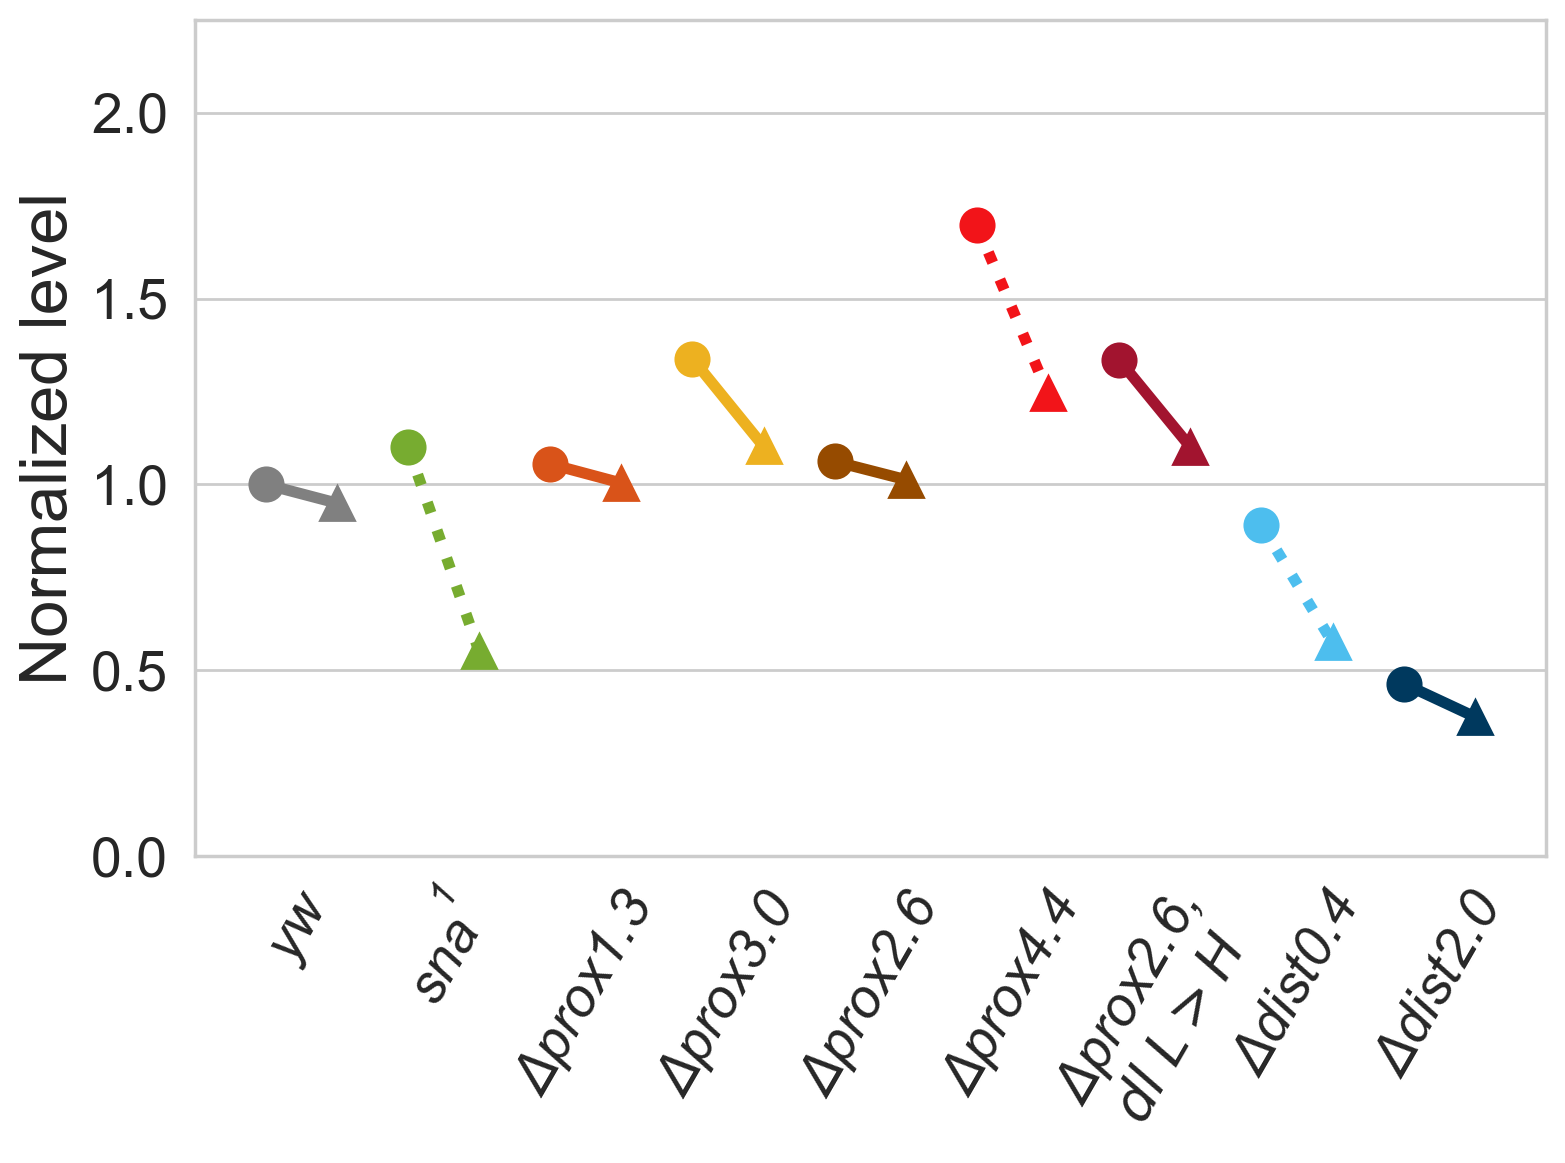

In [5]:
# Set up a figure with axes
fig, ax = plt.subplots(1, 1)

# Label the axes and title the plot
fig.set_size_inches(8, 6)

ind = [0,11,5,6,7,8,10,1,3]
ax.set_ylabel('Normalized level', fontsize=24)

ax.set_xlim([0,len(ind)*2+1])
ax.set_ylim([0,2.25])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

j = 1
for i in range(len(ind)):
    ax.plot(j, sna[ind[i],-1,0]/sna[0,-1,0], 'o', label=labels[ind[i]], color=colors[ind[i]], markersize=12)
    ax.plot(j+1, sna[ind[i],-1,1]/sna[0,-1,0], '^', color=colors[ind[i]], markersize=12)
    # Full [11,8,1]
    # no repressor [0,11,5,6,7,8,10,1,3]
    # dist repressor [11,1]
    # cooperativity [11,6,8,10,1,3]
    if np.any(ind[i] == np.array([11,8,1])):
        ax.plot([j,j+1], [sna[ind[i],-1,0]/sna[0,-1,0],sna[ind[i],-1,1]/sna[0,-1,0]], ':', color=colors[ind[i]], linewidth=4)
    else:
        ax.plot([j,j+1], [sna[ind[i],-1,0]/sna[0,-1,0],sna[ind[i],-1,1]/sna[0,-1,0]], '-', color=colors[ind[i]], linewidth=4)
    
    print('1copy/2copies for {0} = {1:.2f}'.format(simple_labels[ind[i]], sna[ind[i],-1,1]/sna[ind[i],-1,0]))
    
    j += 2

ax.set_xticks(np.arange(0,len(ind)*2,2)+1.5)
ax.set_xticklabels([labels[k] for k in ind], style='italic', rotation=60)
ax.grid(axis='x')
            
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=16);
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=32);
plt.tight_layout()
    
#plt.savefig('/Volumes/James McGehee Mac/Documents/Stathopoulos_Lab/Leslie_sna_paper/Model_1_4_sna_cooperativity1.pdf')

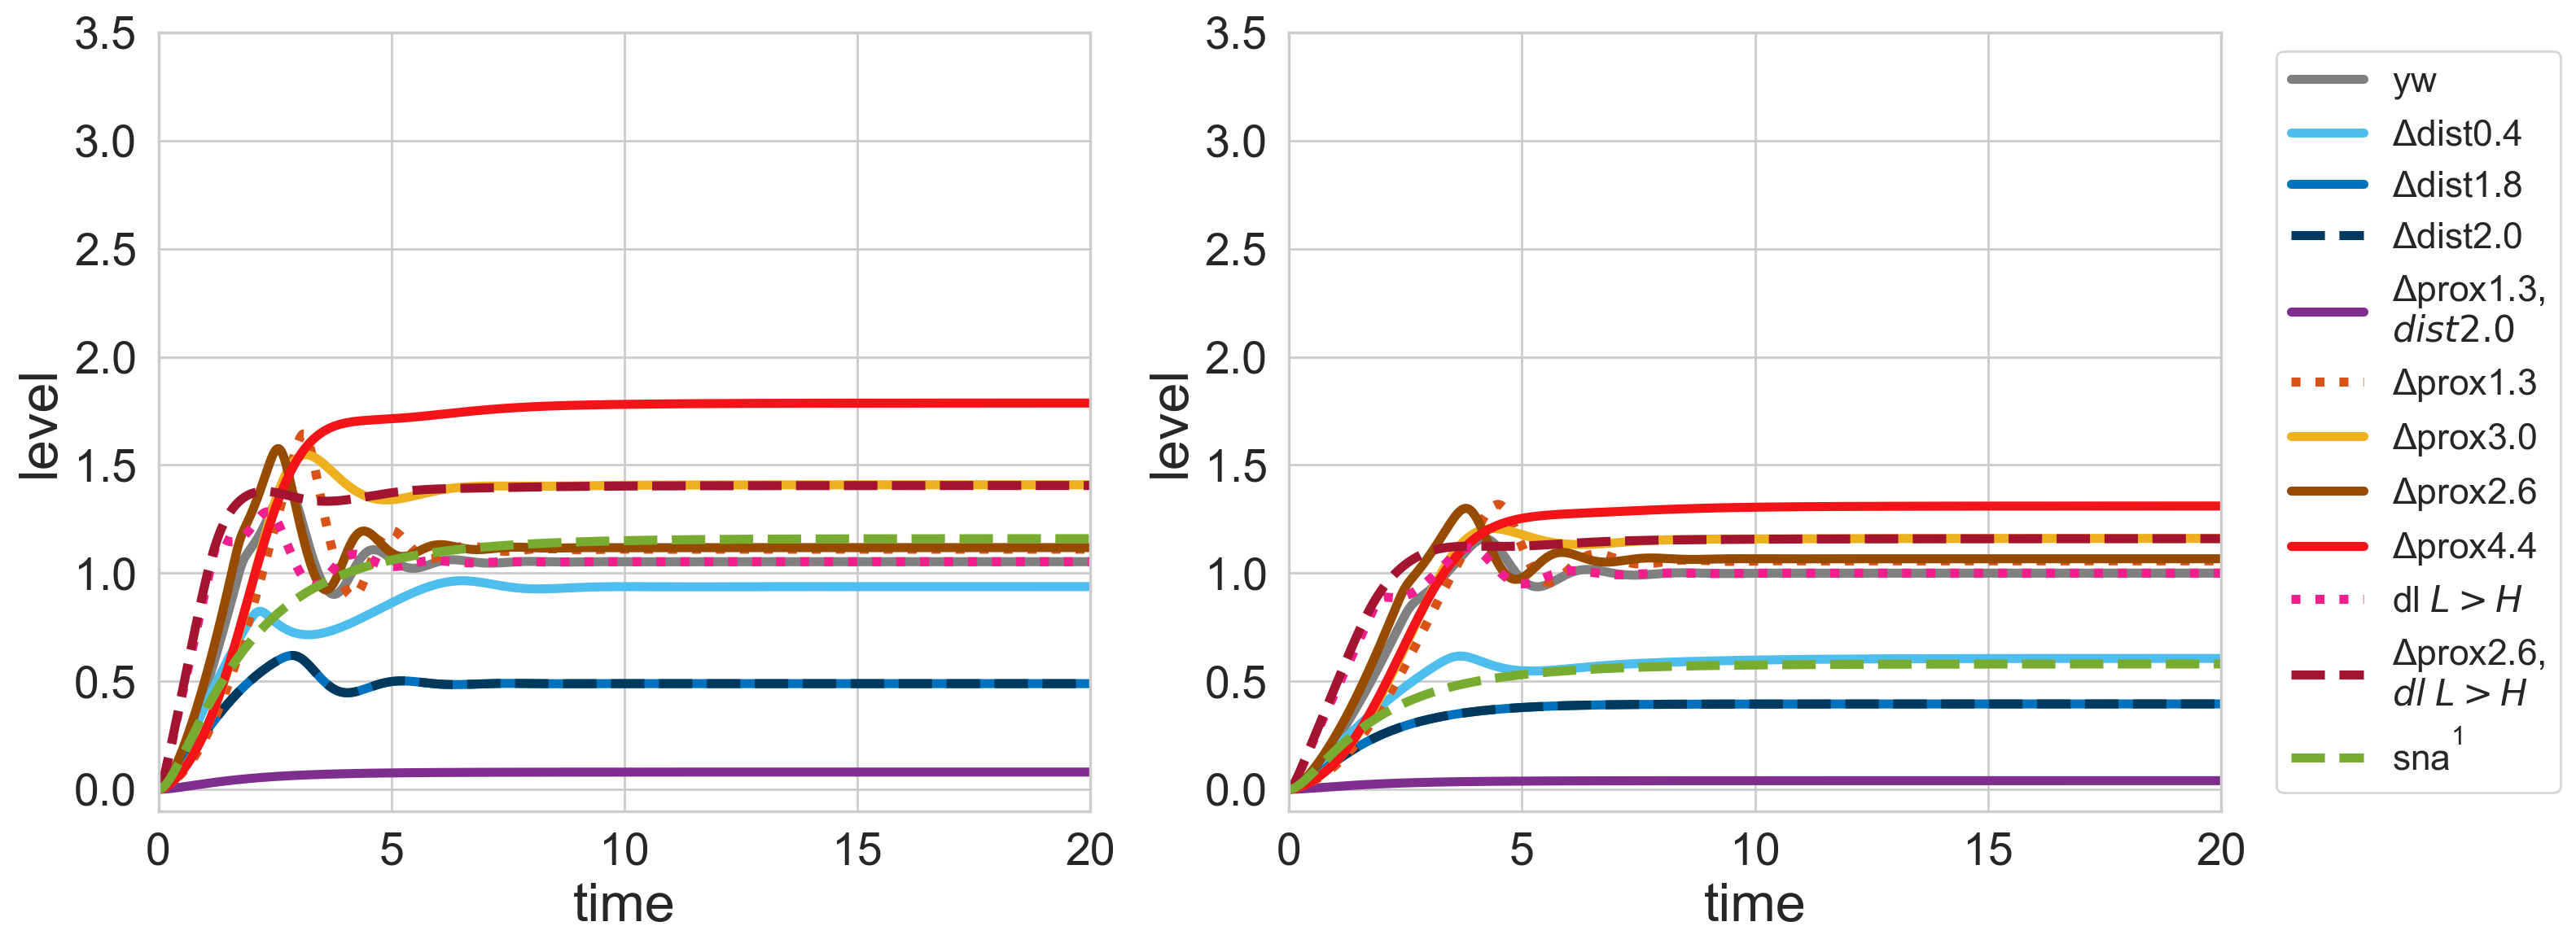

In [6]:
# Set up a figure with axes
fig, ax = plt.subplots(1, 2)

# Label the axes and title the plot
fig.set_size_inches(16, 6)

for j in range(2):
    ax[j].set_xlabel('time', fontsize=24)
    ax[j].set_ylabel('level', fontsize=24)
    ax[j].set_xlim([0,20])
    ax[j].set_ylim([-0.1,3.5])
    ax[j].tick_params(axis='x', labelsize=20)
    ax[j].tick_params(axis='y', labelsize=20)
    for i in range(len(labels)):
        # Make a plot
        if np.any(i == np.array([3, 10, 11])):
            ax[j].plot(t, sna[i,:,j], '--', label=labels[i], color=colors[i], linewidth=4)
        elif np.any(i == np.array([5, 9])):
            ax[j].plot(t, sna[i,:,j], ':', label=labels[i], color=colors[i], linewidth=4)
        else:
            ax[j].plot(t, sna[i,:,j], '-', label=labels[i], color=colors[i], linewidth=4)
            
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=16);
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=32);
plt.tight_layout()
    
#plt.savefig('/Volumes/James McGehee Mac/Documents/Stathopoulos_Lab/Simulations/sna_time_model.pdf')

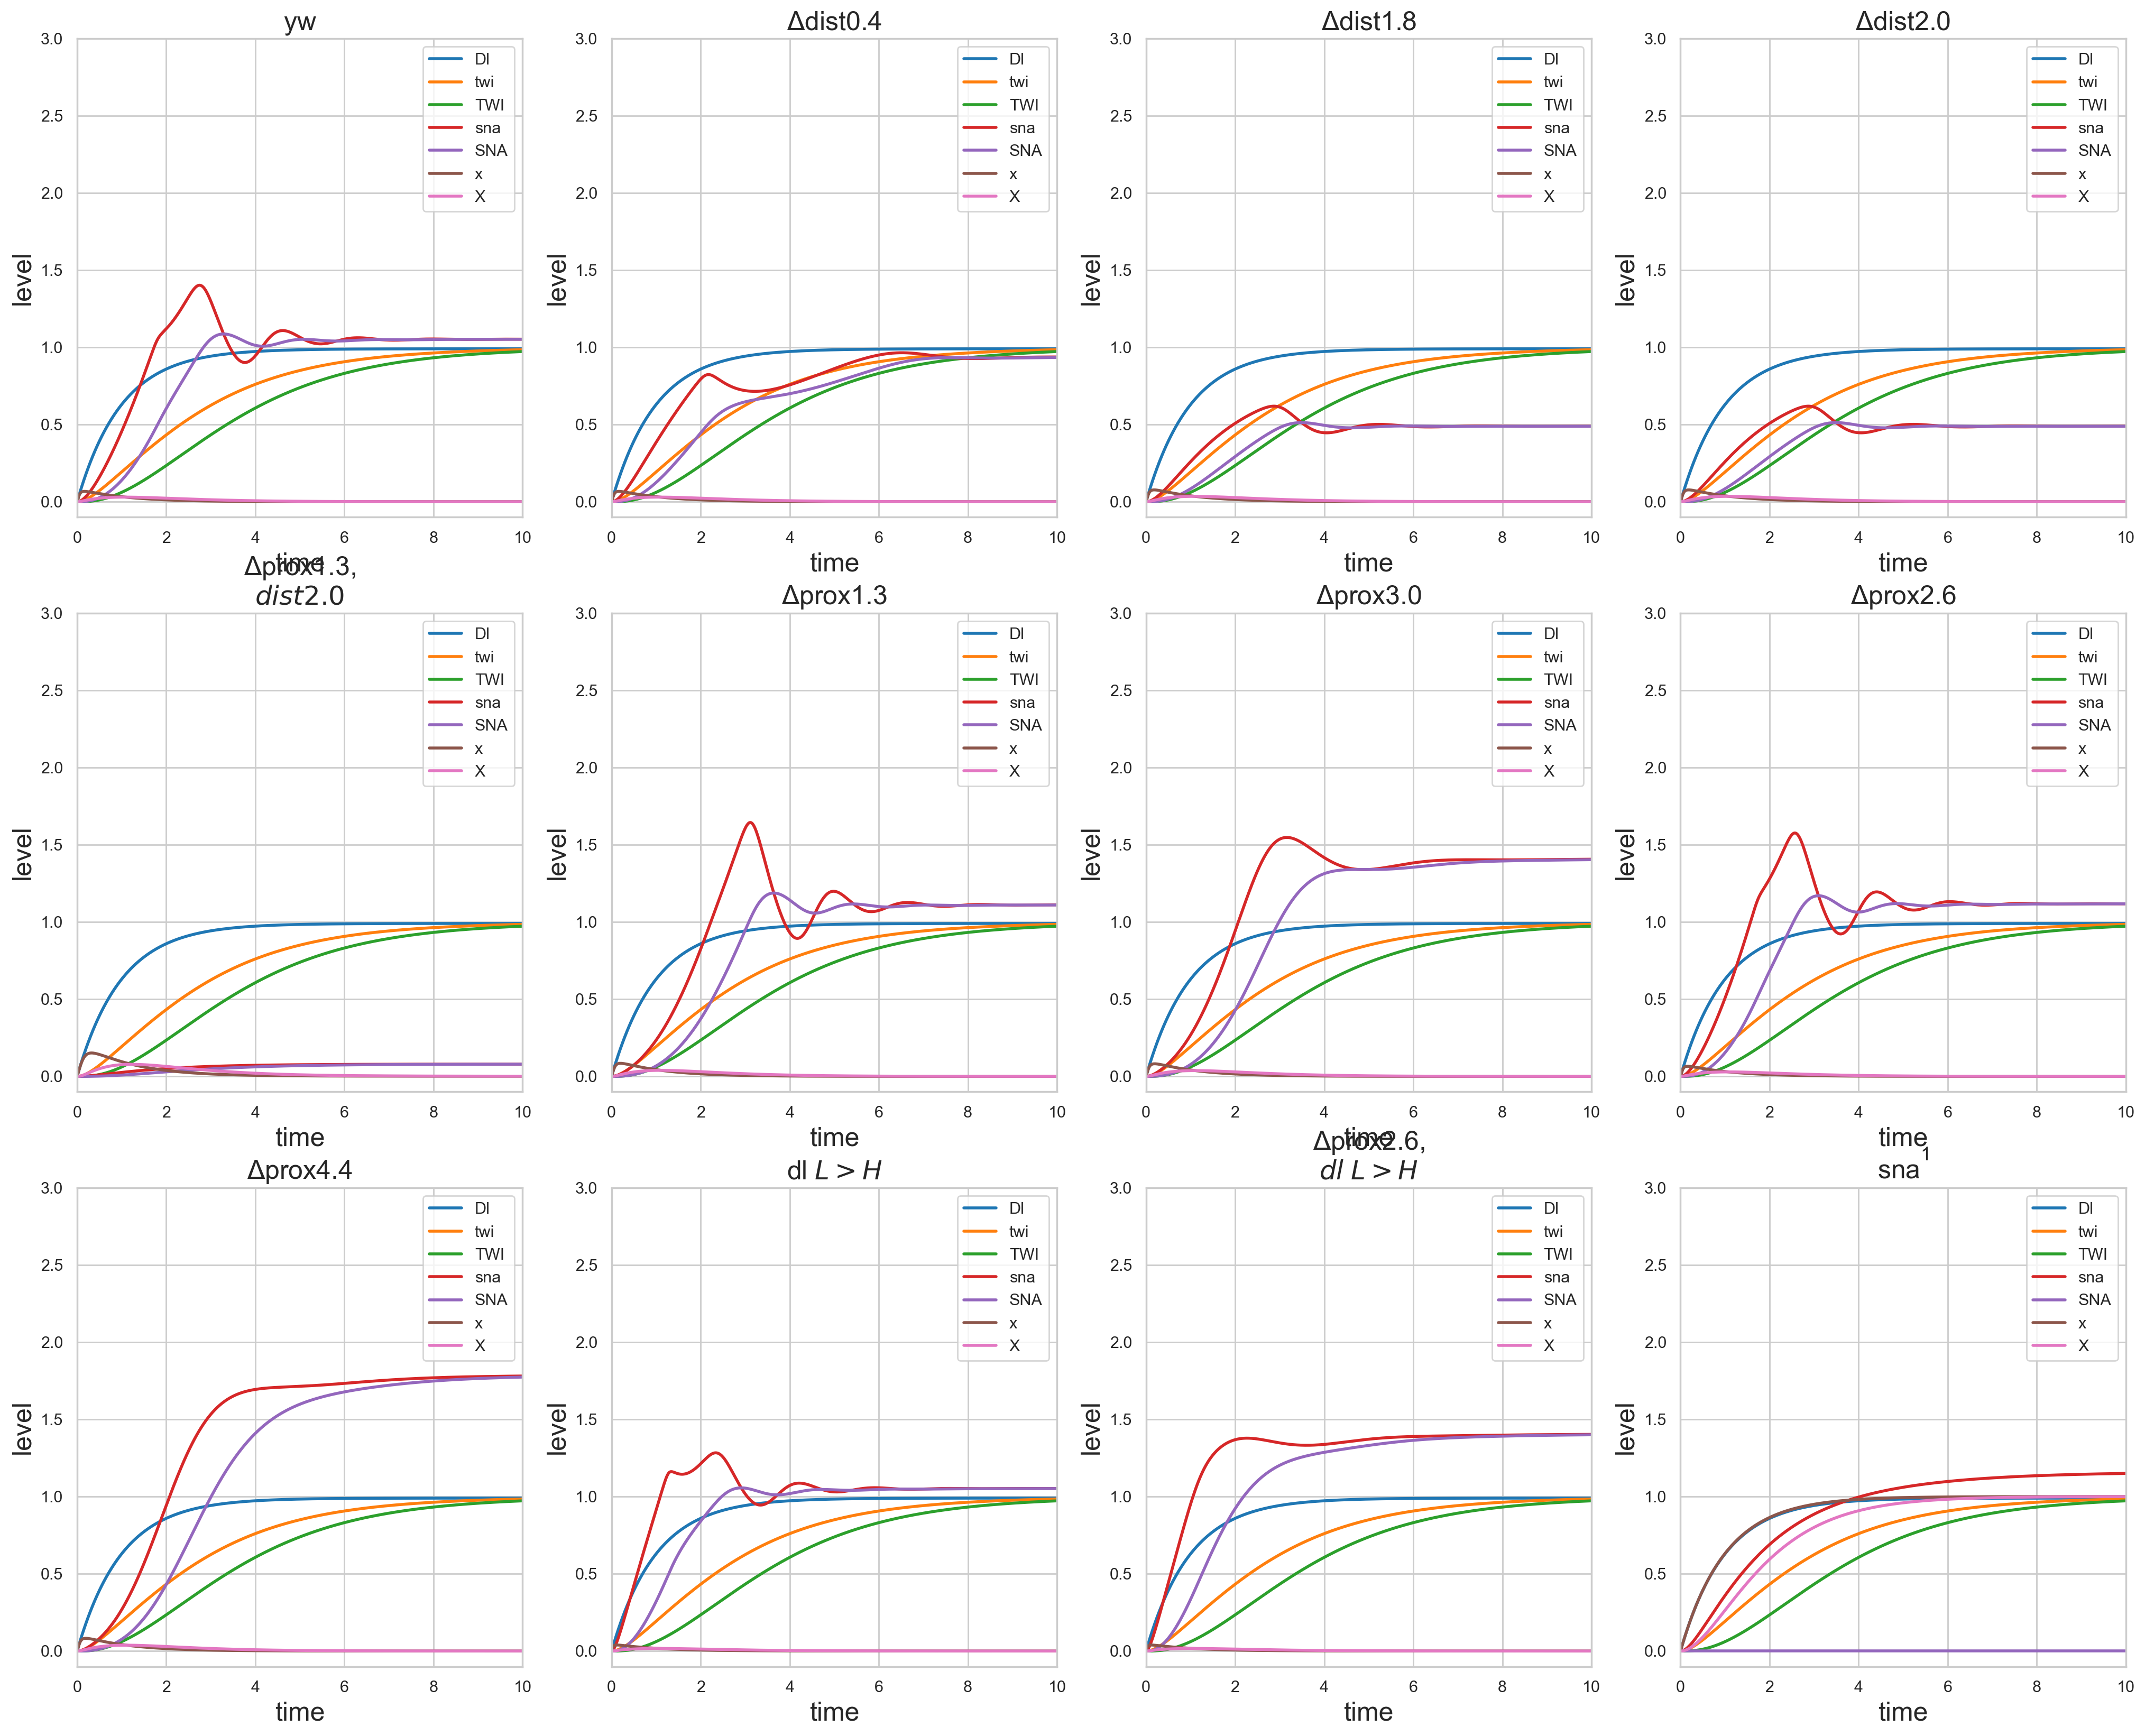

In [7]:
# Set up a figure with axes
fig, ax = plt.subplots(3, 4)

# Label the axes and title the plot
fig.set_size_inches(25, 20)

for i in range(len(labels)):
    j = int(np.floor(i/4))
    k = i % 4
    ax[j,k].set_xlabel('time')
    ax[j,k].set_ylabel('level')
    ax[j,k].set_xlim([0,10])
    ax[j,k].set_ylim([-0.1,3])

    # Make a scatter plot
    ax[j,k].plot(t, DL[i,:,0], label='Dl')
    ax[j,k].plot(t, twi[i,:,0], label='twi')
    ax[j,k].plot(t, TWI[i,:,0], label='TWI')
    ax[j,k].plot(t, sna[i,:,0], label='sna')
    ax[j,k].plot(t, SNA[i,:,0], label='SNA')
    ax[j,k].plot(t, x[i,:,0], label='x')
    ax[j,k].plot(t, X[i,:,0], label='X')
    ax[j,k].legend()
    ax[j,k].title.set_text(labels[i])

In [3]:
def sna_simple(lvl, t, K, n, B_sna, y_sna, B_SNA, y_SNA):
    
    sna, SNA = lvl

    dsna_dt = B_sna * ((K**n)/((K**n)+(SNA**n))) - y_sna * sna

    dSNA_dt = B_SNA * sna - y_SNA * SNA
    
    return (dsna_dt, dSNA_dt)

In [4]:
labels = [r'$\mathdefault{yw}$',#1
          r'$\mathdefault{\Delta dist 0.4}$',#2
          r'$\mathdefault{\Delta dist 1.8}$',#3
          r'$\mathdefault{\Delta dist 2.0}$',#4
          r'$\mathdefault{\Delta prox 1.3,}$' '\n' r'$\mathit{dist 2.0}$',#5
          r'$\mathdefault{\Delta prox 1.3}$',#6
          r'$\mathdefault{\Delta prox 3.0}$',#7
          r'$\mathdefault{\Delta prox 2.6}$',#8
          r'$\mathdefault{\Delta prox 4.4}$',#9
          r'$\mathdefault{dl}$ $\mathit{L > H}$',#10
          r'$\mathdefault{\Delta prox 2.6,}$' '\n' r'$\mathit{dl}$ $\mathit{L > H}$',#11
          r'$\mathdefault{sna^1}$']#12

simple_labels = ['yw',#1
          'dist 0.4',#2
          'dist 1.8',#3
          'dist 2.0',#4
          'prox 1.3,dist 2.0',#5
          'prox 1.3',#6
          'prox 3.0',#7
          'prox 2.6',#8
          'prox 4.4',#9
          'dl L > H',#10
          'prox 2.6, dl L > H}',#11
          'sna^1']#12



K = 0.1 * np.array([1, 1.15, 0.5, 0.5, 0.1, 1, 1.1, 1, 1.2, 1, 1.1, 1])
n = 20 * np.array([1, 1, 1, 1, 1, 1, 0.2, 1, 0.1, 1, 0.1, 1])

# Params for 2 copies, and 1 copy
B_sna2 = np.array([1.0, 0.17, 0.5, 0.5, 0.05, 0.7, 0.45, 0.7, 0.65, 0.7, 0.45, 1.0])
B_sna1 = 0.5 * B_sna2
B_sna = 1 * np.vstack((B_sna2, B_sna1))
y_sna = 1
B_SNA = 1 * np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
y_SNA = 1

c0 = np.array([0.0, 0.0])
t = np.linspace(0.0, 100, 10001)

sna = np.zeros([len(labels),len(t),2])
SNA = np.zeros([len(labels),len(t),2])

for j in range(2):
    for i in range(len(labels)):
        args = (K[i], n[i], B_sna[j,i], y_sna, B_SNA[i], y_SNA)
        
        lvls = scipy.integrate.odeint(sna_simple, c0, t, args=args)
        sna[i,:,j], SNA[i,:,j] = lvls.transpose()

1copy/2copies for yw = 0.96
1copy/2copies for sna^1 = 0.50
1copy/2copies for prox 1.3 = 0.96
1copy/2copies for prox 3.0 = 0.82
1copy/2copies for prox 2.6 = 0.96
1copy/2copies for prox 4.4 = 0.74
1copy/2copies for dl L > H = 0.96
1copy/2copies for prox 2.6, dl L > H} = 0.73
1copy/2copies for dist 0.4 = 0.76
1copy/2copies for dist 1.8 = 0.96
1copy/2copies for dist 2.0 = 0.96
1copy/2copies for prox 1.3,dist 2.0 = 0.95


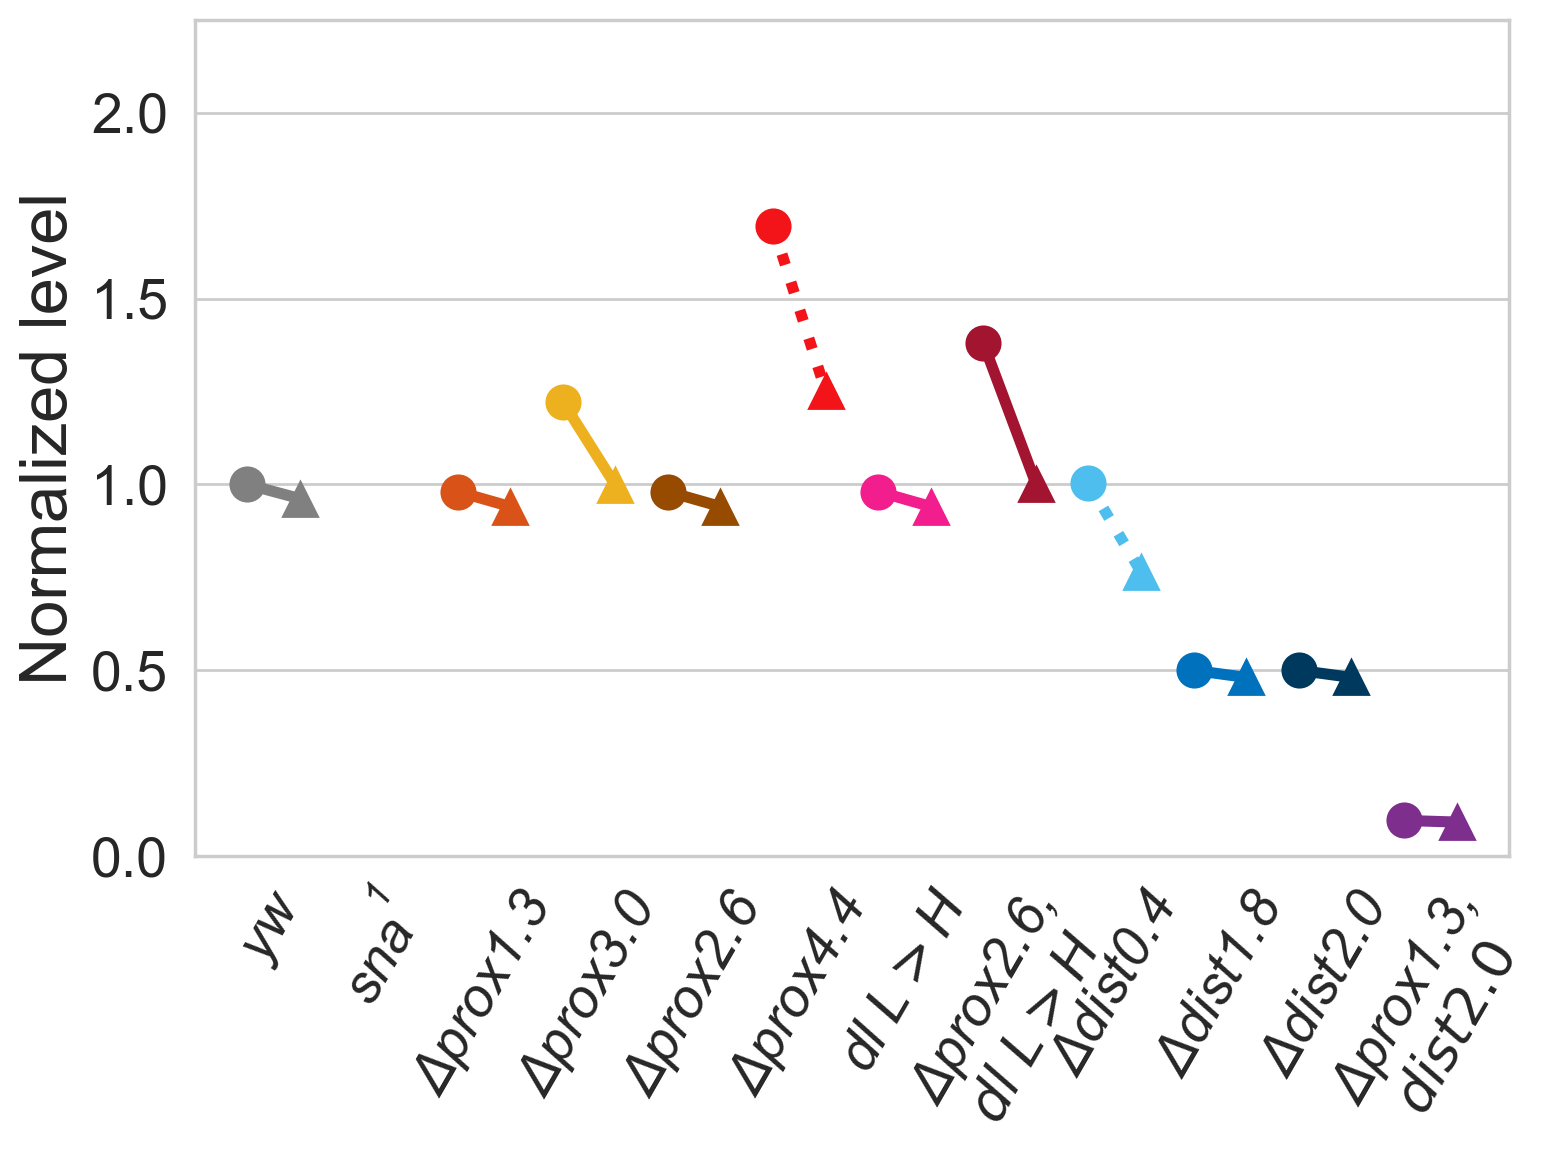

In [5]:
# Set up a figure with axes
fig, ax = plt.subplots(1, 1)

# Label the axes and title the plot
fig.set_size_inches(8, 6)

#ind = [0,11,5,6,7,8,10,1,3]
ind = [0,11,5,6,7,8,9,10,1,2,3,4]
ax.set_ylabel('Normalized level', fontsize=24)

ax.set_xlim([0,len(ind)*2+1])
ax.set_ylim([0,2.25])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

j = 1
for i in range(len(ind)):
    ax.plot(j, sna[ind[i],-1,0]/sna[0,-1,0], 'o', label=labels[ind[i]], color=colors[ind[i]], markersize=12)
    ax.plot(j+1, sna[ind[i],-1,1]/sna[0,-1,0], '^', color=colors[ind[i]], markersize=12)
    # Full [11,8,1]
    # no repressor [0,11,5,6,7,8,10,1,3]
    # dist repressor [11,1]
    # cooperativity [11,6,8,10,1,3]
    if np.any(ind[i] == np.array([11,8,1])):
        ax.plot([j,j+1], [sna[ind[i],-1,0]/sna[0,-1,0],sna[ind[i],-1,1]/sna[0,-1,0]], ':', color=colors[ind[i]], linewidth=4)
    else:
        ax.plot([j,j+1], [sna[ind[i],-1,0]/sna[0,-1,0],sna[ind[i],-1,1]/sna[0,-1,0]], '-', color=colors[ind[i]], linewidth=4)
    
    print('1copy/2copies for {0} = {1:.2f}'.format(simple_labels[ind[i]], sna[ind[i],-1,1]/sna[ind[i],-1,0]))
    
    j += 2

ax.set_xticks(np.arange(0,len(ind)*2,2)+1.5)
ax.set_xticklabels([labels[k] for k in ind], style='italic', rotation=60)
ax.grid(axis='x')
            
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=16);
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=32);
plt.tight_layout()
    
#plt.savefig('/Volumes/James McGehee Mac/Documents/Stathopoulos_Lab/Leslie_sna_paper/Model_1_4_sna_cooperativity1.pdf')

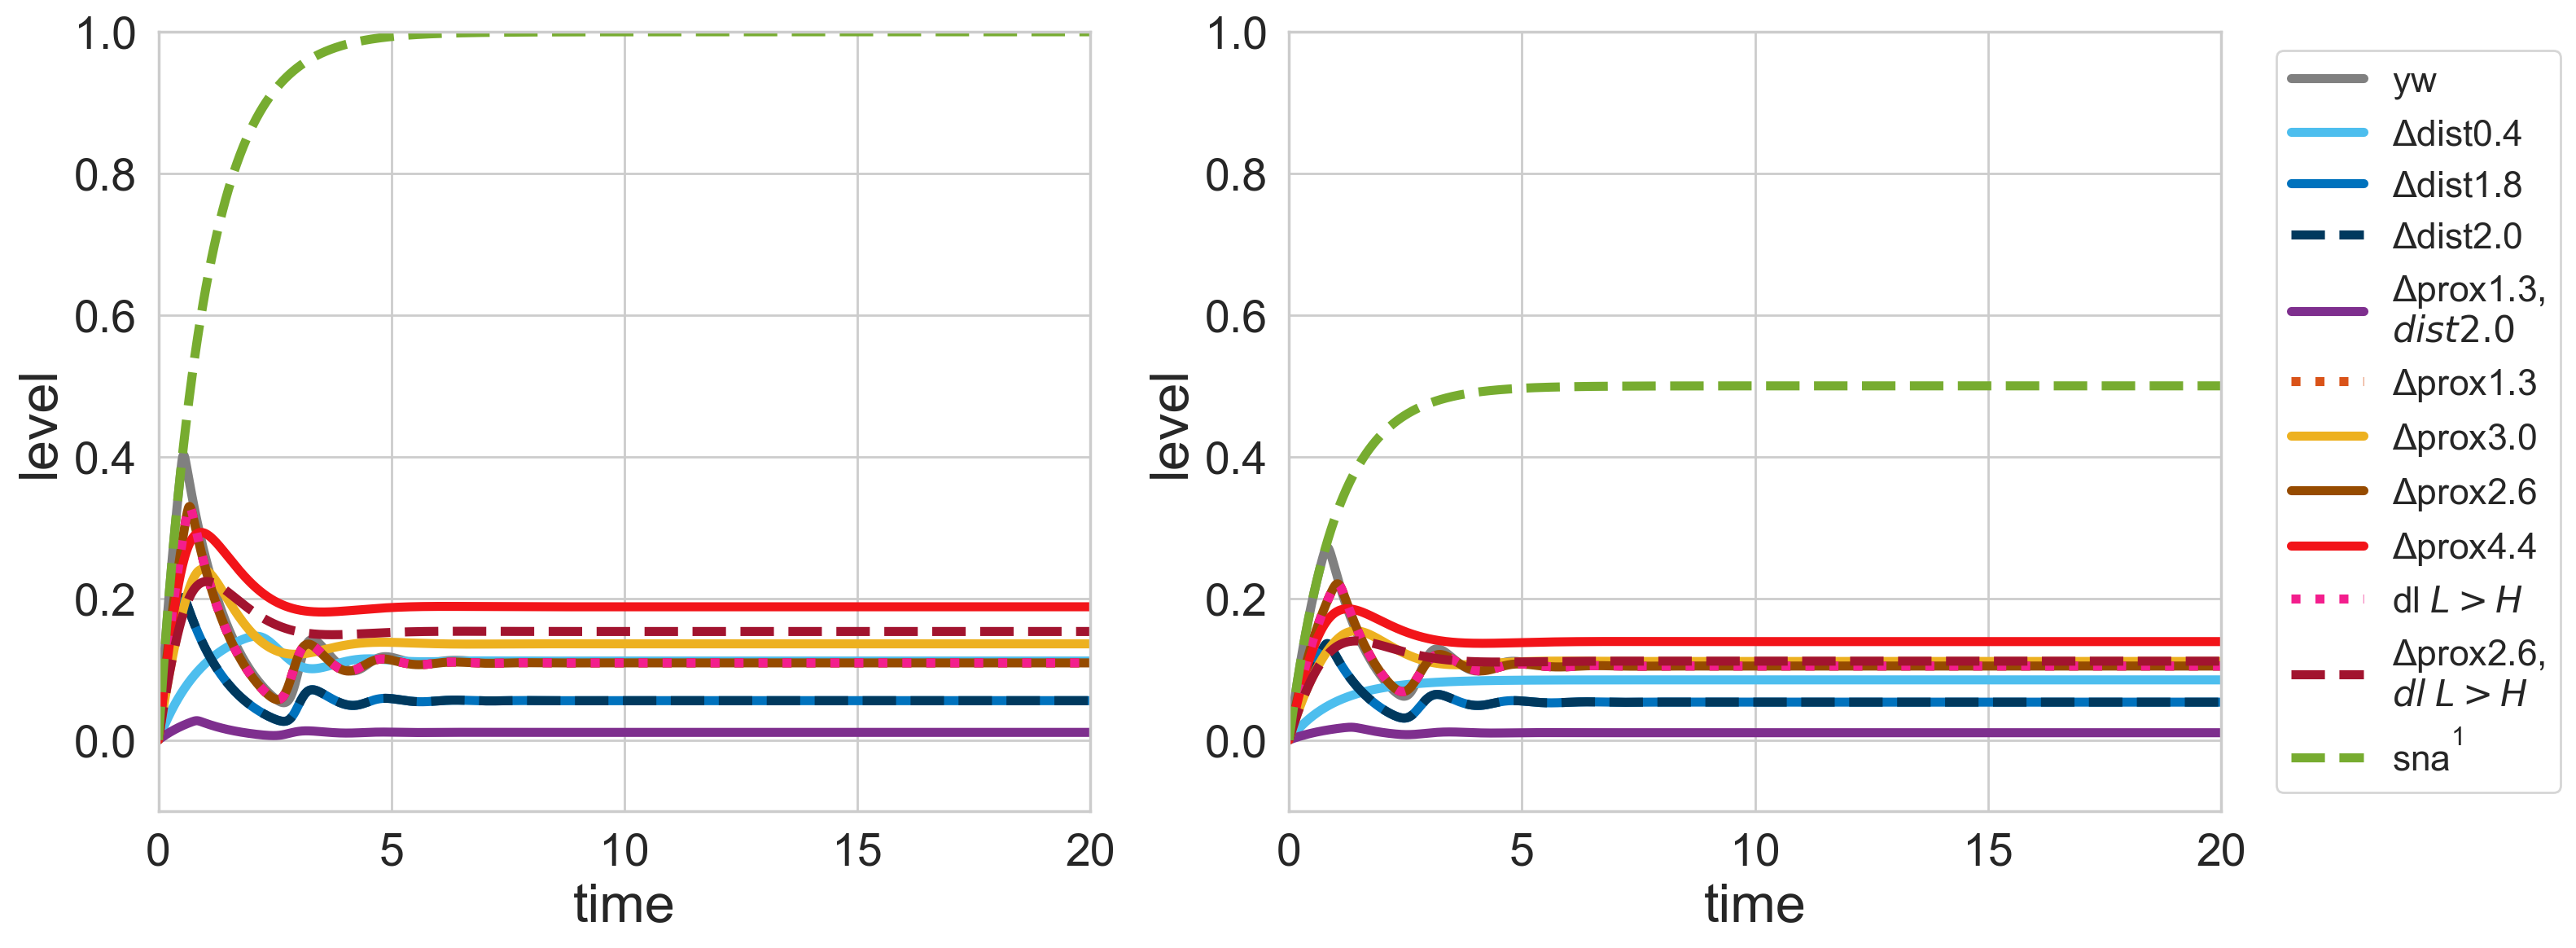

In [6]:
# Set up a figure with axes
fig, ax = plt.subplots(1, 2)

# Label the axes and title the plot
fig.set_size_inches(16, 6)

for j in range(2):
    ax[j].set_xlabel('time', fontsize=24)
    ax[j].set_ylabel('level', fontsize=24)
    ax[j].set_xlim([0,20])
    ax[j].set_ylim([-0.1,1])
    ax[j].tick_params(axis='x', labelsize=20)
    ax[j].tick_params(axis='y', labelsize=20)
    for i in range(len(labels)):
        # Make a plot
        if np.any(i == np.array([3, 10, 11])):
            ax[j].plot(t, sna[i,:,j], '--', label=labels[i], color=colors[i], linewidth=4)
        elif np.any(i == np.array([5, 9])):
            ax[j].plot(t, sna[i,:,j], ':', label=labels[i], color=colors[i], linewidth=4)
        else:
            ax[j].plot(t, sna[i,:,j], '-', label=labels[i], color=colors[i], linewidth=4)
            
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=16);
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=32);
plt.tight_layout()
    
#plt.savefig('/Volumes/James McGehee Mac/Documents/Stathopoulos_Lab/Simulations/sna_time_model.pdf')

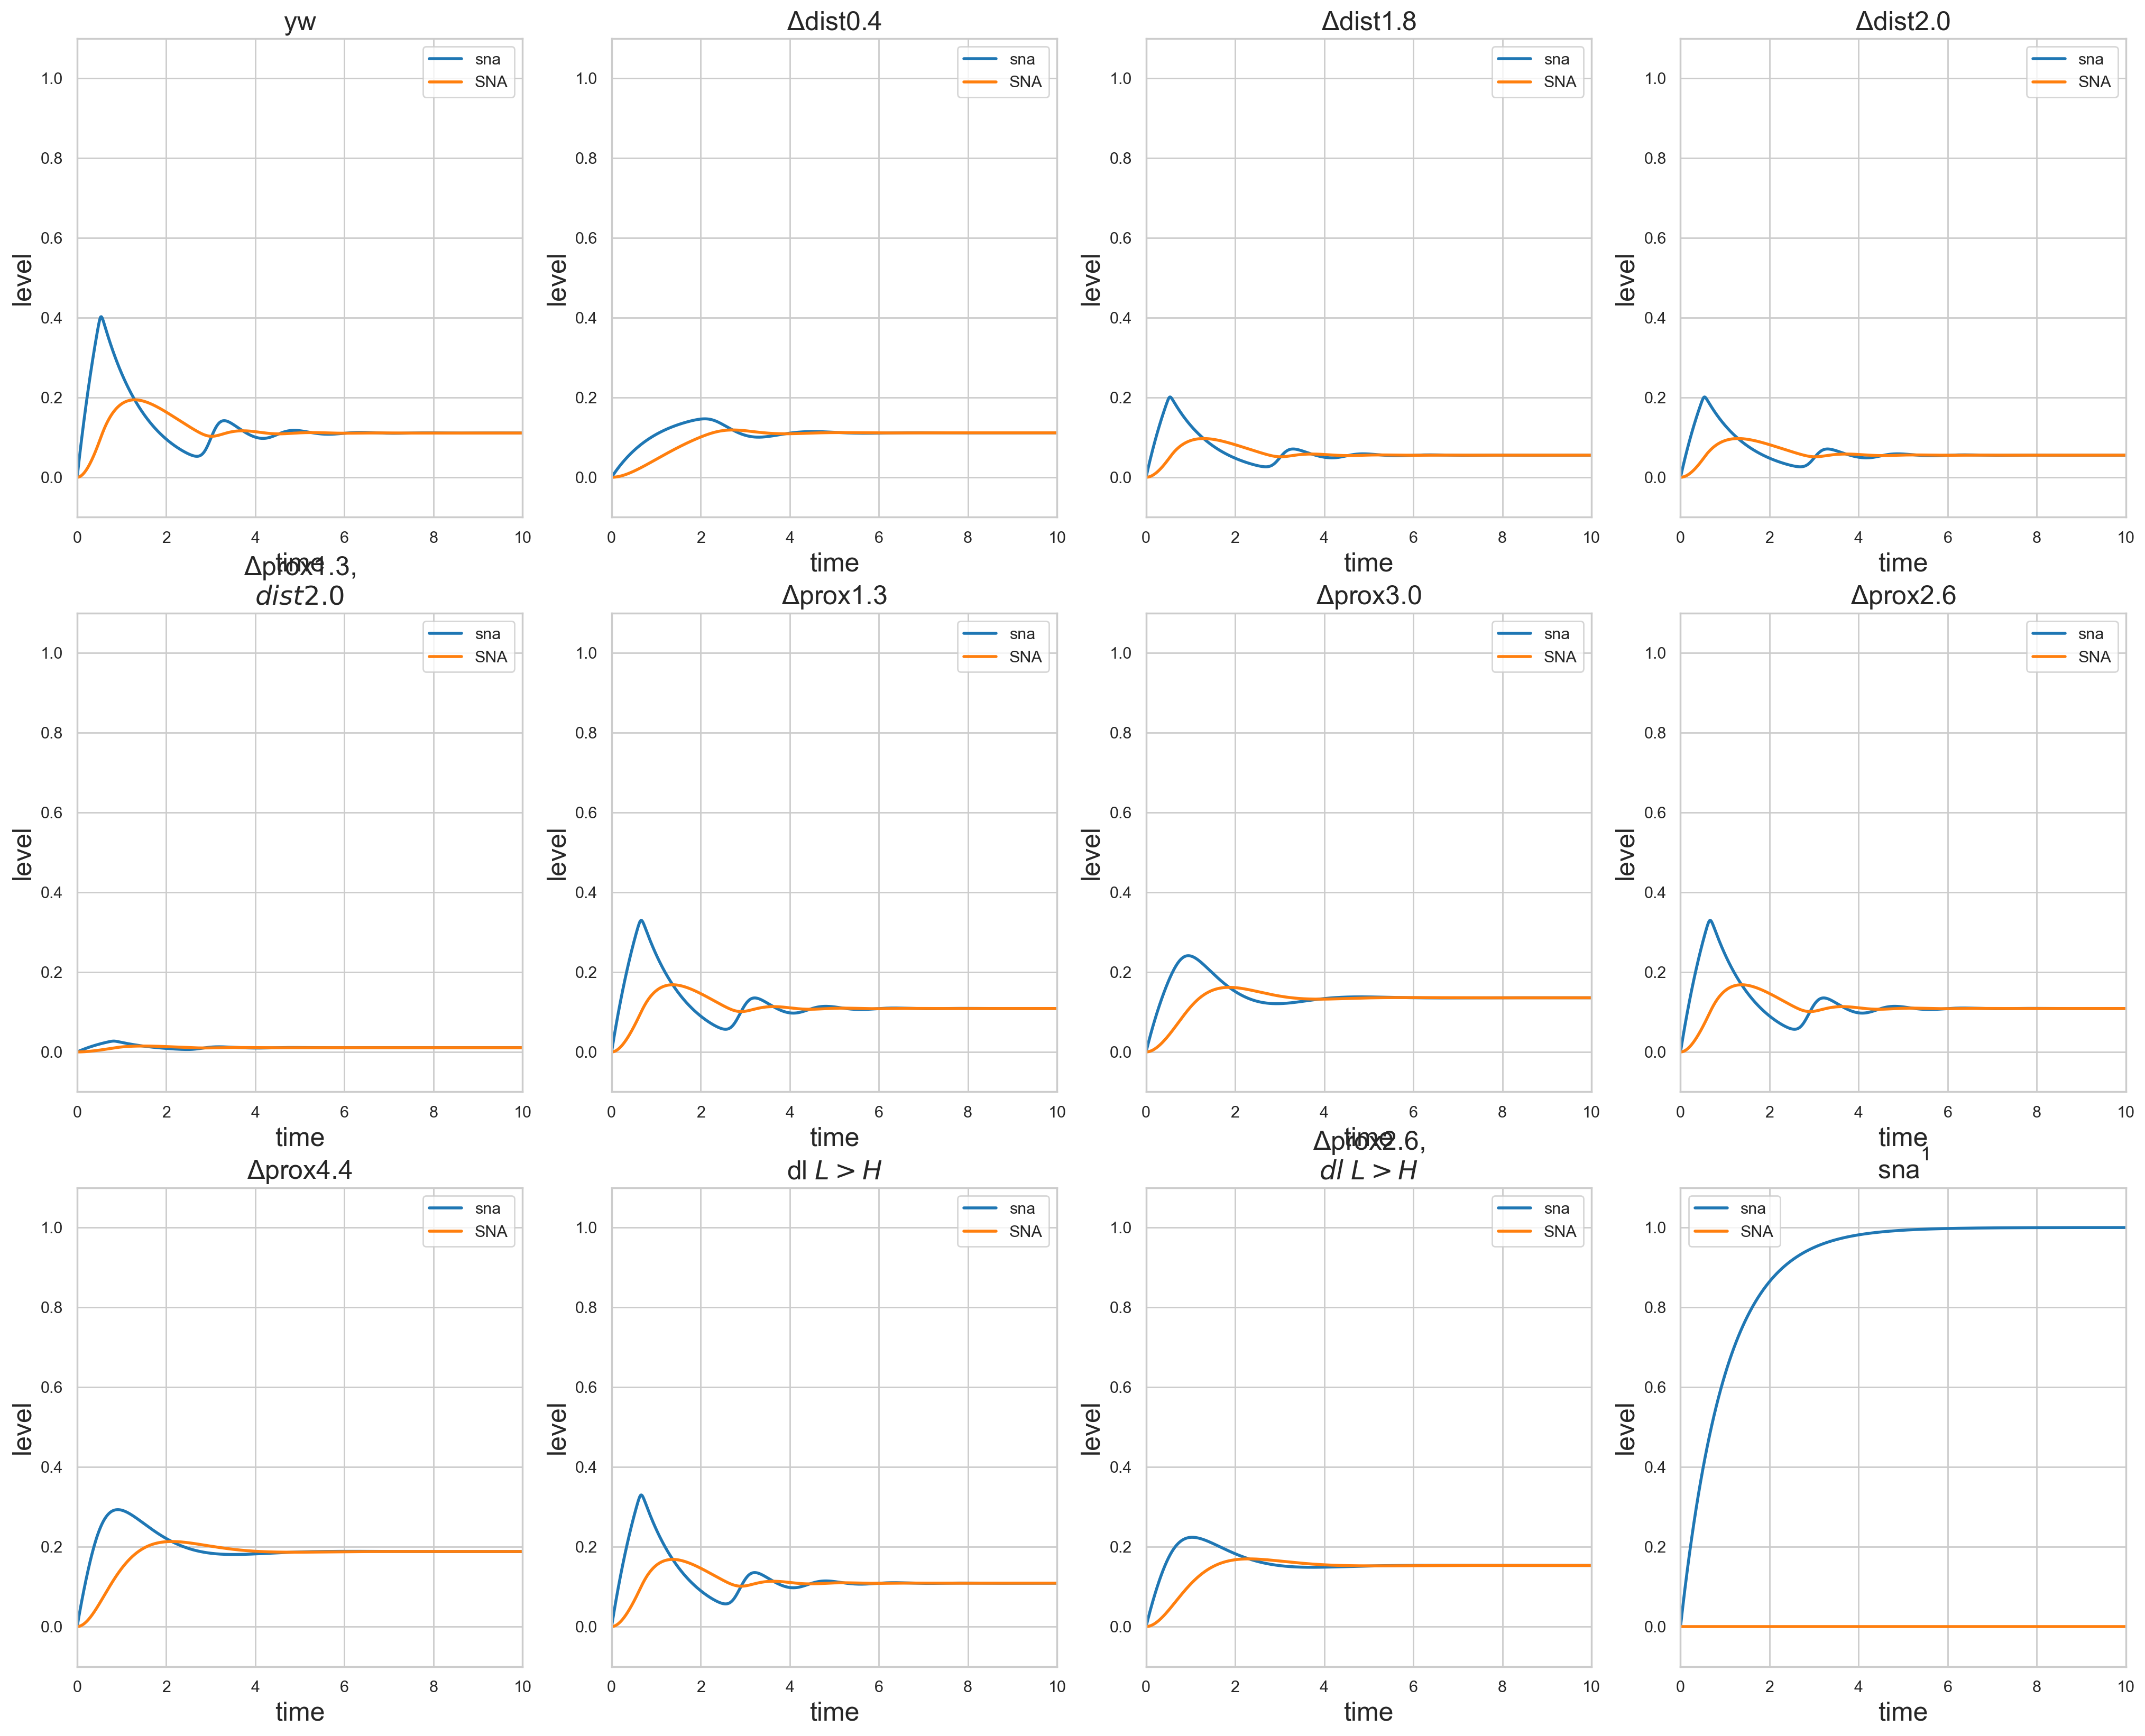

In [7]:
# Set up a figure with axes
fig, ax = plt.subplots(3, 4)

# Label the axes and title the plot
fig.set_size_inches(25, 20)

for i in range(len(labels)):
    j = int(np.floor(i/4))
    k = i % 4
    ax[j,k].set_xlabel('time')
    ax[j,k].set_ylabel('level')
    ax[j,k].set_xlim([0,10])
    ax[j,k].set_ylim([-0.1,1.1])

    # Make a scatter plot
    ax[j,k].plot(t, sna[i,:,0], label='sna')
    ax[j,k].plot(t, SNA[i,:,0], label='SNA')
    ax[j,k].legend()
    ax[j,k].title.set_text(labels[i])

In [108]:
def sna_simple_nond(lvl, t, n, B, y):
    
    m, p = lvl

    dm_dt = (1/(1+p**n)) - m

    dp_dt = (B * m - p) * y
    
    return (dm_dt, dp_dt)

In [152]:
n = 4

# Params for 2 copies, and 1 copy
B2 = 0.5
B1 = 0.5 * B2
B = np.vstack((B2, B1))
y = 1

c0 = np.array([0.0, 0.0])
t = np.linspace(0.0, 100, 10001)

m = np.zeros([len(t), 2])
p = np.zeros([len(t), 2])

for j in range(2):
    args = (n, B[j,0], y)
    
    lvls = scipy.integrate.odeint(sna_simple_nond, c0, t, args=args)
    m[:,j], p[:,j] = lvls.transpose()

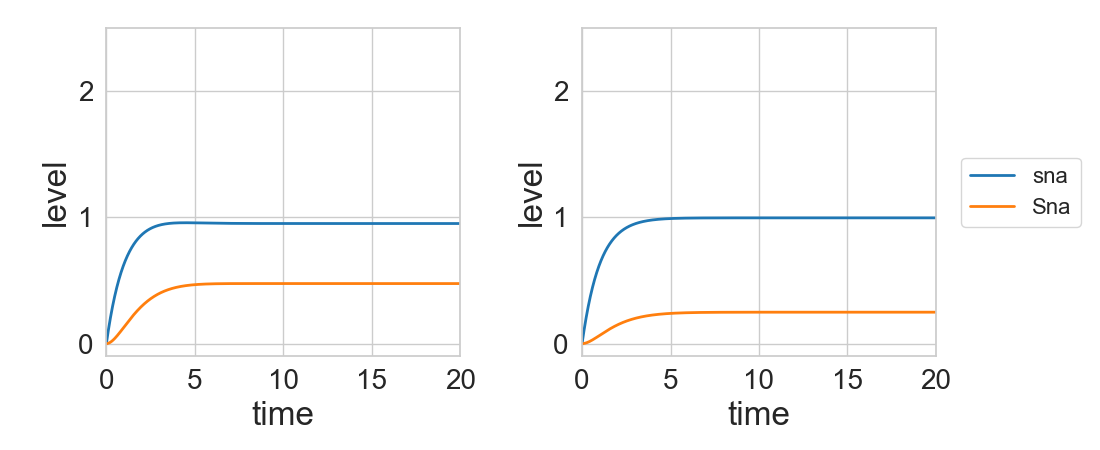

In [145]:
plt.close()

# Set up a figure with axes
fig, ax = plt.subplots(1, 2)

# Label the axes and title the plot
fig.set_size_inches(11, 4.5)

for j in range(2):
    ax[j].set_xlabel('time', fontsize=24)
    ax[j].set_ylabel('level', fontsize=24)
    ax[j].set_xlim([0,20])
    ax[j].set_ylim([-0.1,2.5])
    ax[j].tick_params(axis='x', labelsize=20)
    ax[j].tick_params(axis='y', labelsize=20)
    ax[j].plot(t, m[:,j], label='sna')
    ax[j].plot(t, p[:,j], label='Sna')
            
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=16);
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=32);
plt.tight_layout()
    
#plt.savefig('/Volumes/James McGehee Mac/Documents/Stathopoulos_Lab/Simulations/sna_time_model.pdf')

In [73]:
#filename = '/Volumes/James McGehee Mac/Documents/MATLAB_data/leslie_sna_HCR_quantification/averages.csv'
filename = '/Users/jamesmcgehee/Desktop/averages.csv'
csvFile = pd.read_csv(filename)
array_means = csvFile[['mean 2 copies', 'mean 1 copies']].to_numpy()

In [4]:
#@jit(nopython=True)
def param_search_nondim(expected):
    
    thresholds = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.25, 0.05]
    R = np.linspace(0.1,50,500)
    n = np.linspace(1,20,20, dtype='int')
    
    base_array = np.zeros((np.shape(R)[0]*np.shape(n)[0], 5))
    output_arr = np.empty((len(expected)), dtype=object)
    
    for i in range(len(expected)):
        output_arr[i] = base_array.copy()
        
    ind = [0 for _ in range(len(expected))]
    
    for i in range(np.shape(R)[0]):
        for j in range(np.shape(n)[0]):
            p2 = np.zeros((n[j]+2))
            p2[0] = 1
            p2[-2] = 1
            p2[-1] = -R[i]
            p2_roots = np.roots(p2)
            sna2 = np.real(p2_roots[np.isreal(p2_roots) & (p2_roots > 0)])[0]
        
            p1 = p2
            p1[-1] = -0.5 * R[i]
            p1_roots = np.roots(p1)
            sna1 = np.real(p1_roots[np.isreal(p1_roots) & (p1_roots > 0)])[0]

            for k in range(10):
                if k == 9:
                    sna2 = R[i]
                    sna1 = 0.5 * R[i]
                    
                if abs((expected[k,1]/expected[k,0]) - (sna1/sna2))/(expected[k,1]/expected[k,0]) < thresholds[k]:
                    output_arr[k][ind[k],:] = [R[i], n[j], sna2, sna1, sna1/sna2]
                    ind[k] = ind[k] + 1
    
    return output_arr

In [5]:
start_time = time.time()

output_arr = param_search_nondim(array_means)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 2.619358777999878 seconds


In [6]:
#@jit(nopython=True)
def param_search_mutant(expected, input_arr):

    thresholds = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 2, 0.02]
    arr = input_arr.copy()
    arr[0] = arr[0][np.any(arr[0] != 0, axis=1)]
    mutant_arr = np.empty((len(arr)-1), dtype=object)
    
    for i in range(1, len(arr)):
        arr[i] = arr[i][np.any(arr[i] != 0, axis=1)]
        mutant_arr[i-1] = np.zeros((np.shape(arr[i])[0],np.shape(arr[0])[0]), dtype=bool)
        for j in range(np.shape(arr[i])[0]):
            for k in range(np.shape(arr[0])[0]):
                if ((abs(expected[i,0] - (arr[i][j,2]/arr[0][k,2]))/expected[i,0]) < (thresholds[i-1])):# \
                    #& (abs(expected[d,1] - input_arr[d][j,2]/input_arr[d][i,2])/expected[d,1] < 0.1):
                    mutant_arr[i-1][j,k] = True
    
    return mutant_arr, arr

In [7]:
start_time = time.time()

mutant_arr, arr = param_search_mutant(array_means, output_arr)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 36.086437940597534 seconds


In [8]:
find_yw = np.zeros((np.shape(mutant_arr[0])[1], len(mutant_arr)), dtype=bool)

for i in range(len(mutant_arr)):
    find_yw[:,i] = np.any(mutant_arr[i], axis=0)

yw_params = np.all(find_yw, axis=1)

In [9]:
# Convert the array to a dataframe
df = pd.DataFrame(find_yw)
# Alternatively, you can directly assign new column names
df.columns = ['dprox 1.3', 'dprox 3.0', 'dprox 2.6', 'dprox 4.4', 'dl L>H', 'dprox 2.6 dl L>H', 'ddist 0.4', 'ddist 2.0', 'sna1']
# Drop rows where all values are zero
#df = df[(df != 0).any(axis=1)]
print(df)

      dprox 1.3  dprox 3.0  dprox 2.6  dprox 4.4  dl L>H  dprox 2.6 dl L>H  \
0          True       True       True       True    True              True   
1          True       True       True       True    True              True   
2          True       True       True       True    True              True   
3          True       True       True       True    True              True   
4          True       True       True       True    True              True   
...         ...        ...        ...        ...     ...               ...   
2136       True      False       True       True    True             False   
2137       True      False       True       True    True             False   
2138       True      False       True       True    True              True   
2139       True      False       True       True    True              True   
2140       True      False       True       True    True              True   

      ddist 0.4  ddist 2.0   sna1  
0          True       True 

In [272]:
# Save the DataFrame to a CSV file
#filename_out = '/Volumes/James McGehee Mac/Documents/MATLAB_data/leslie_sna_HCR_quantification/find_yw.csv'
#df.to_csv(filename_out, index=False)

In [10]:
mutant_params = np.empty((len(arr)), dtype=object)

mutant_params[0] = arr[0][yw_params,:]

for i in range(1,len(mutant_params)):
    mutant_params[i] = arr[i][np.any(mutant_arr[i-1][:,yw_params], axis=1),:]

In [26]:
# Convert the array to a dataframe
df = pd.DataFrame(arr[8])
# Alternatively, you can directly assign new column names
df.columns = ['R', 'n', '2copies', '1copy', '1copy/2copies']
# Drop rows where all values are zero
df = df[(df != 0).any(axis=1)]
print(df)

                  R     n   2copies     1copy  1copy/2copies
0          7.488104  20.0  1.092385  1.048354       0.959693
1          8.603464  19.0  1.105976  1.060560       0.958935
2          8.603464  20.0  1.100721  1.057640       0.960861
3          9.884959  19.0  1.114681  1.070038       0.959950
4          9.884959  20.0  1.108968  1.066639       0.961831
..              ...   ...       ...       ...            ...
400  1000000.000000  16.0  2.253934  2.163881       0.960047
401  1000000.000000  17.0  2.154434  2.073048       0.962224
402  1000000.000000  18.0  2.069138  1.995013       0.964176
403  1000000.000000  19.0  1.995262  1.927296       0.965936
404  1000000.000000  20.0  1.930698  1.868011       0.967532

[405 rows x 5 columns]


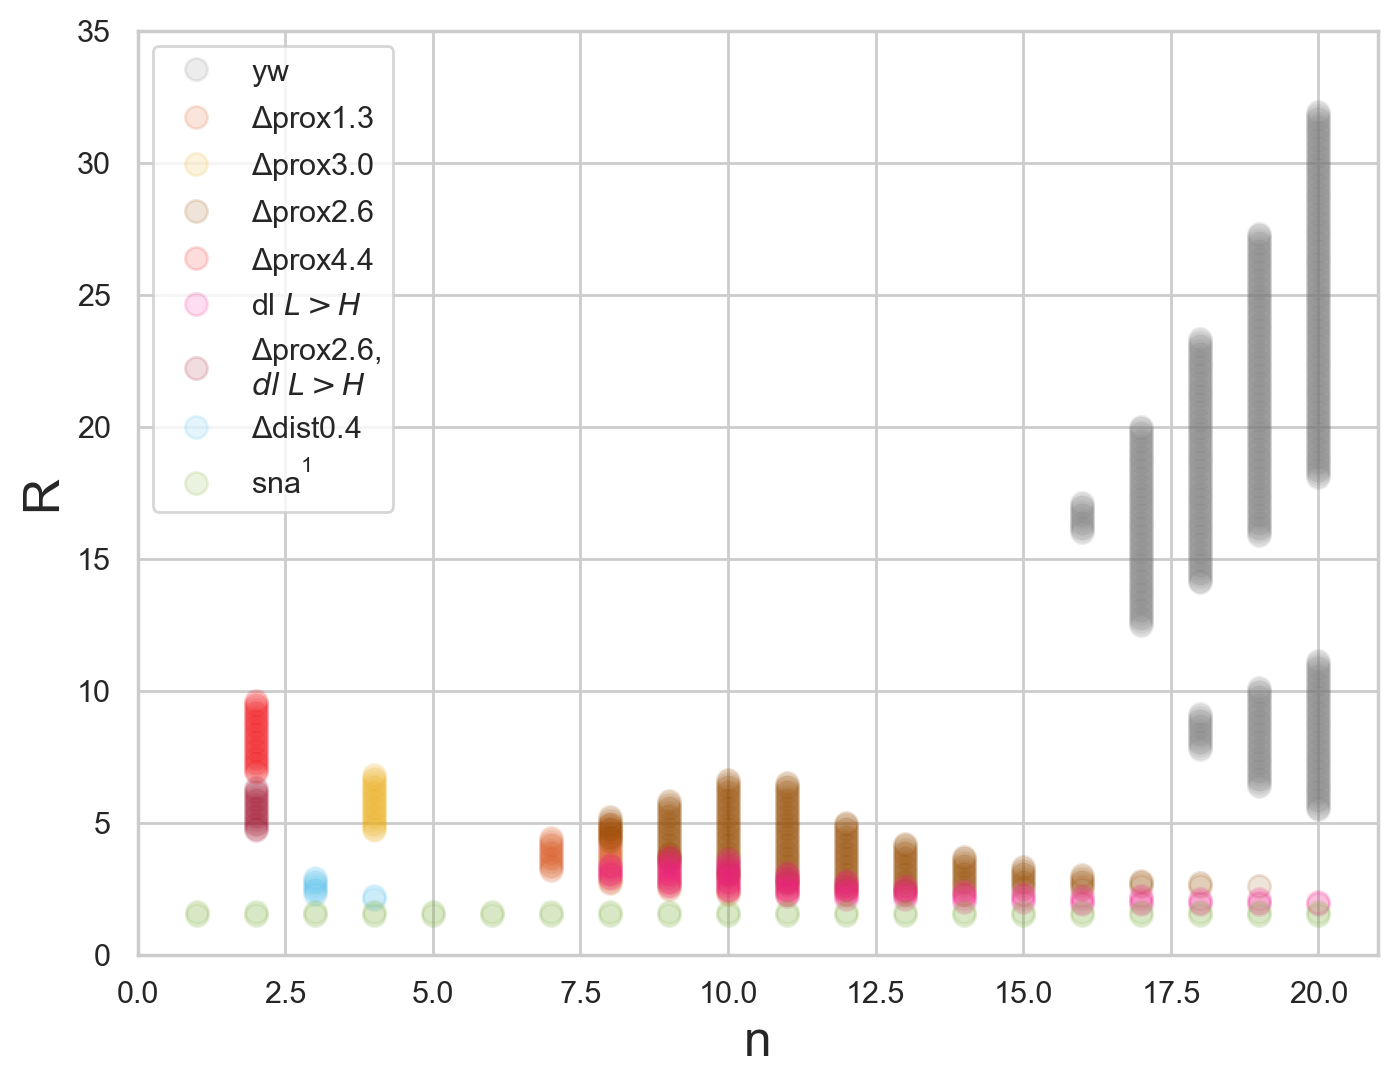

In [11]:
labels = [r'$\mathdefault{yw}$',#1
          r'$\mathdefault{\Delta dist 0.4}$',#2
          r'$\mathdefault{\Delta dist 1.8}$',#3
          r'$\mathdefault{\Delta dist 2.0}$',#4
          r'$\mathdefault{\Delta prox 1.3,}$' '\n' r'$\mathit{dist 2.0}$',#5
          r'$\mathdefault{\Delta prox 1.3}$',#6
          r'$\mathdefault{\Delta prox 3.0}$',#7
          r'$\mathdefault{\Delta prox 2.6}$',#8
          r'$\mathdefault{\Delta prox 4.4}$',#9
          r'$\mathdefault{dl}$ $\mathit{L > H}$',#10
          r'$\mathdefault{\Delta prox 2.6,}$' '\n' r'$\mathit{dl}$ $\mathit{L > H}$',#11
          r'$\mathdefault{sna^1}$']#12

ind_lab = [0, 5, 6, 7, 8, 9, 10, 1, 11]
ind = [0,1,2,3,4,5,6,7,9]

# Set up a figure with axes
fig, ax = plt.subplots(1, 1)

# Label the axes and title the plot
fig.set_size_inches(8, 6)

for i in range(len(ind_lab)):
    ax.set_xlabel('n')
    ax.set_ylabel('R')
    ax.set_xlim([0,21])
    ax.set_ylim([0,35])

    # Make a scatter plot
    ax.plot(mutant_params[ind[i]][:,1], mutant_params[ind[i]][:,0], 'o', label=labels[ind_lab[i]], markersize=8, alpha=0.15, color=colors[ind_lab[i]])
    ax.legend()

In [236]:
#@jit(nopython=True)
def param_search_dim(expected):
    
    thresholds = [0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015]
    D = 10**np.linspace(-3,3,7)
    E = 10**np.linspace(-3,3,7)
    n = np.linspace(1,20,20, dtype='int')
    
    base_array = np.zeros((np.shape(D)[0]*np.shape(E)[0]*np.shape(n)[0], 6))
    output_arr = np.empty((len(array_means)), dtype=object)
    
    for m in range(len(expected)):
        output_arr[m] = base_array.copy()
        
    ind = [0 for _ in range(len(expected))]
    
    for i in range(np.shape(D)[0]):
        for j in range(np.shape(E)[0]):
            for k in range(np.shape(n)[0]):
                p2 = np.zeros((n[k]+2))
                p2[0] = D[i]
                p2[-2] = 1
                p2[-1] = -E[j]
                p2_roots = np.roots(p2)
                sna2 = np.real(p2_roots[np.isreal(p2_roots) & (p2_roots > 0)])
            
                p1 = p2
                p1[-1] = -0.5 * E[j]
                p1_roots = np.roots(p1)
                sna1 = np.real(p1_roots[np.isreal(p1_roots) & (p1_roots > 0)])
    
                for m in range(10):
                    if abs((expected[m,1]/expected[m,0]) - (sna1[0]/sna2[0]))/(expected[m,1]/expected[m,0]) < thresholds[m]:
                        output_arr[m][ind[m],:] = [D[i], E[j], n[k], sna2[0], sna1[0], sna1[0]/sna2[0]]
                        ind[m] = ind[m] + 1
    
    return output_arr

In [237]:
start_time = time.time()

output_arr = param_search_dim(array_means)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.30481410026550293 seconds


In [238]:
#@jit(nopython=True)
def param_search_mutant(expected, input_arr):

    thresholds = [0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015]
    arr = input_arr.copy()
    arr[0] = arr[0][np.any(arr[0] != 0, axis=1)]
    mutant_arr = np.empty((len(arr)-1), dtype=object)
    
    for i in range(1, len(arr)):
        arr[i] = arr[i][np.any(arr[i] != 0, axis=1)]
        mutant_arr[i-1] = np.zeros((np.shape(arr[i])[0],np.shape(arr[0])[0]), dtype=bool)
        for j in range(np.shape(arr[i])[0]):
            for k in range(np.shape(arr[0])[0]):
                if ((abs(expected[i,0] - (arr[i][j,3]/arr[0][k,3]))/expected[i,0]) < (thresholds[i-1])):
                    mutant_arr[i-1][j,k] = True
    
    return mutant_arr, arr

In [239]:
start_time = time.time()

mutant_arr, arr = param_search_mutant(array_means, output_arr)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.03500699996948242 seconds


In [240]:
find_yw = np.zeros((np.shape(mutant_arr[0])[1], len(mutant_arr)), dtype=bool)

for i in range(len(mutant_arr)):
    find_yw[:,i] = np.any(mutant_arr[i], axis=0)

yw_params = np.all(find_yw[:,0:7], axis=1)

In [241]:
# Convert the array to a dataframe
df = pd.DataFrame(find_yw)
# Alternatively, you can directly assign new column names
df.columns = ['dprox 1.3', 'dprox 3.0', 'dprox 2.6', 'dprox 4.4', 'dl L>H', 'dprox 2.6 dl L>H', 'ddist 0.4', 'ddist 2.0', 'sna1']
# Drop rows where all values are zero
#df = df[(df != 0).any(axis=1)]
print(df)

    dprox 1.3  dprox 3.0  dprox 2.6  dprox 4.4  dl L>H  dprox 2.6 dl L>H  \
0       False      False       True      False    True             False   
1       False      False       True      False   False             False   
2       False      False       True      False   False             False   
3       False      False      False      False   False             False   
4       False      False       True      False   False             False   
..        ...        ...        ...        ...     ...               ...   
59      False      False      False      False   False             False   
60      False      False      False      False   False             False   
61      False      False      False      False   False             False   
62      False      False      False      False   False             False   
63      False      False      False      False   False             False   

    ddist 0.4  ddist 2.0   sna1  
0       False      False  False  
1       False      

In [172]:
# Save the DataFrame to a CSV file
filename_out = '/Volumes/James McGehee Mac/Documents/MATLAB_data/leslie_sna_HCR_quantification/find_yw.csv'
df.to_csv(filename_out, index=False)

In [194]:
mutant_params = np.empty((len(arr)), dtype=object)

mutant_params[0] = arr[0][yw_params,:]

for i in range(1,len(mutant_params)):
    mutant_params[i] = arr[i][np.any(mutant_arr[i-1][:,yw_params], axis=1),:]

In [244]:
# Convert the array to a dataframe
df = pd.DataFrame(output_arr[1])
# Alternatively, you can directly assign new column names
df.columns = ['D', 'E', 'n', '2copies', '1copy', '1copy/2copies']
# Drop rows where all values are zero
df = df[(df != 0).any(axis=1)]
print(df)

           D       E    n    2copies      1copy  1copy/2copies
0      0.001    10.0  7.0   3.023135   2.640054       0.873283
1      0.001    10.0  8.0   2.687454   2.396144       0.891604
2      0.001   100.0  5.0   6.734216   5.942957       0.882502
3      0.001  1000.0  4.0  15.798534  13.720728       0.868481
4      0.001  1000.0  5.0   9.983292   8.882412       0.889728
5      0.010    10.0  6.0   2.571174   2.232860       0.868421
6      0.010    10.0  7.0   2.295326   2.036894       0.887410
7      0.010   100.0  5.0   4.605259   4.076978       0.885288
8      0.010  1000.0  4.0   9.979960   8.675085       0.869251
9      0.010  1000.0  5.0   6.805172   6.057305       0.890103
10     0.100    10.0  6.0   1.874292   1.651348       0.881051
11     0.100   100.0  5.0   3.145478   2.790433       0.887125
12     0.100  1000.0  4.0   6.301601   5.480708       0.869733
13     0.100  1000.0  5.0   4.637994   4.129474       0.890358
14     1.000    10.0  5.0   1.430515   1.246628       0

In [243]:
# Save the DataFrame to a CSV file
filename_out = '/Volumes/James McGehee Mac/Documents/MATLAB_data/leslie_sna_HCR_quantification/params.csv'
df.to_csv(filename_out, index=False)

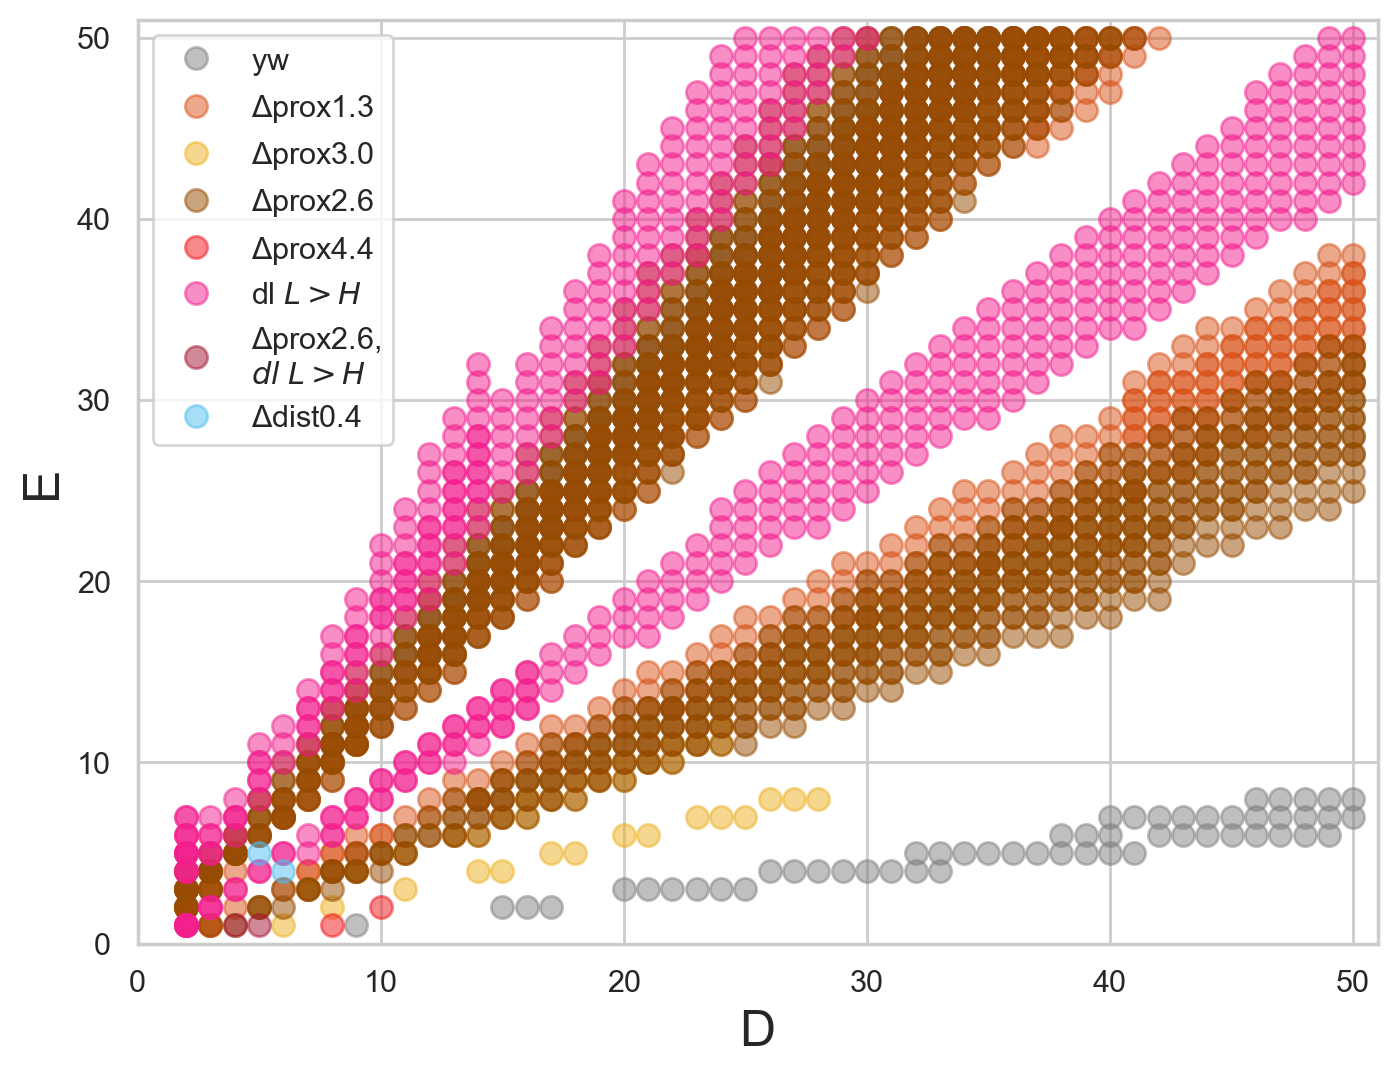

In [210]:
labels = [r'$\mathdefault{yw}$',#1
          r'$\mathdefault{\Delta dist 0.4}$',#2
          r'$\mathdefault{\Delta dist 1.8}$',#3
          r'$\mathdefault{\Delta dist 2.0}$',#4
          r'$\mathdefault{\Delta prox 1.3,}$' '\n' r'$\mathit{dist 2.0}$',#5
          r'$\mathdefault{\Delta prox 1.3}$',#6
          r'$\mathdefault{\Delta prox 3.0}$',#7
          r'$\mathdefault{\Delta prox 2.6}$',#8
          r'$\mathdefault{\Delta prox 4.4}$',#9
          r'$\mathdefault{dl}$ $\mathit{L > H}$',#10
          r'$\mathdefault{\Delta prox 2.6,}$' '\n' r'$\mathit{dl}$ $\mathit{L > H}$',#11
          r'$\mathdefault{sna^1}$']#12

ind_lab = [0, 5, 6, 7, 8, 9, 10, 1]
ind = [0,1,2,3,4,5,6,7]

# Set up a figure with axes
fig, ax = plt.subplots(1, 1)

# Label the axes and title the plot
fig.set_size_inches(8, 6)

for i in range(len(ind_lab)):
    ax.set_xlabel('D')
    ax.set_ylabel('E')
    ax.set_xlim([0,51])
    ax.set_ylim([0,51])

    # Make a scatter plot
    ax.plot(mutant_params[ind[i]][:,1], mutant_params[ind[i]][:,0], 'o', label=labels[ind_lab[i]], markersize=8, alpha=0.5, color=colors[ind_lab[i]])
    ax.legend()

In [3]:
def root_fun(m, beta, n):
    return m - 1 / (1 + (beta * m)**n)

def _msolve(beta, n):
    return scipy.optimize.brentq(root_fun, 0, 1, args=(beta, n))

def msolve(beta, n):
    if np.isscalar(beta):
        if np.isscalar(n):
            result = _msolve(beta, n)
        else:
            raise ValueError('beta and n must both be scalar or both be vector')
    else:
        if np.isscalar(n):
            raise ValueError('beta and n must both be scalar or both be vector')
        else:
            result = np.empty((len(n), len(beta)))
            for i, n_ in enumerate(n):
                for j, beta_ in enumerate(beta):
                    result[i, j] = _msolve(beta_, n_)

    return result

In [4]:
#n = [1, 4, 10]
#n = [0.9, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 10]
#n = [0.9, 3.2, 10]
n = np.linspace(0.1, 10, 10)
beta = np.linspace(0.0, 3, 501)
m = msolve(beta, n)

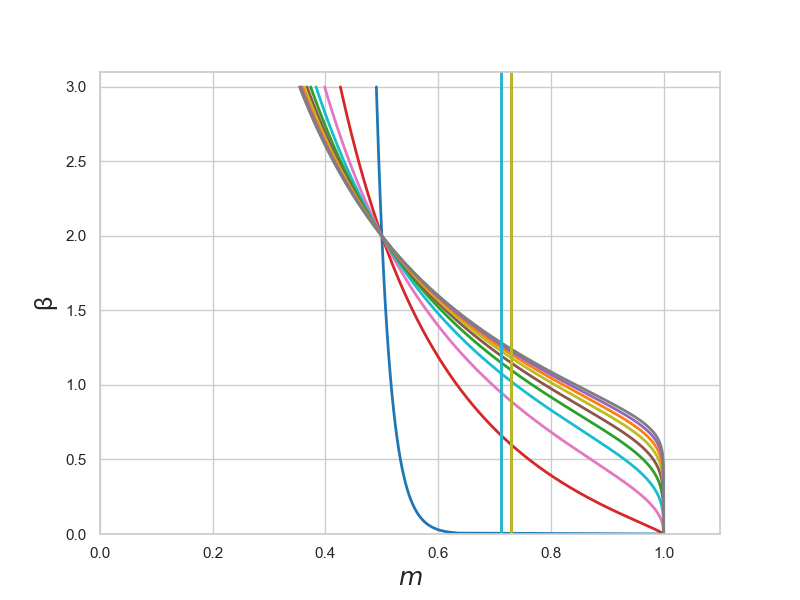

In [6]:
plt.close()

# Set up a figure with axes
fig, ax = plt.subplots(1, 1)

# Label the axes and title the plot
fig.set_size_inches(8, 6)

for i, n_ in enumerate(n):
    ax.set_xlabel('$m$')
    ax.set_ylabel(r'$\mathdefault{\beta}$')
    ax.set_xlim([0,1.1])
    ax.set_ylim([0,3.1])

    # Make a scatter plot
    ax.plot(m[i, :], beta, linewidth=2)
    ax.plot([0.729291228,0.729291228], [0, 30], linewidth=2)
    ax.plot([0.711303241,0.711303241], [0, 30], linewidth=2)

In [7]:
ind_lab = np.array([0, 5, 6, 7, 8, 9, 10, 1, 3, 11], dtype=int)

beta = np.linspace(0, 10, 501)
n = np.linspace(0.1, 20, 500)
m = msolve(beta, n)

# Create data for the contour plot
BETA, N = np.meshgrid(beta, n)

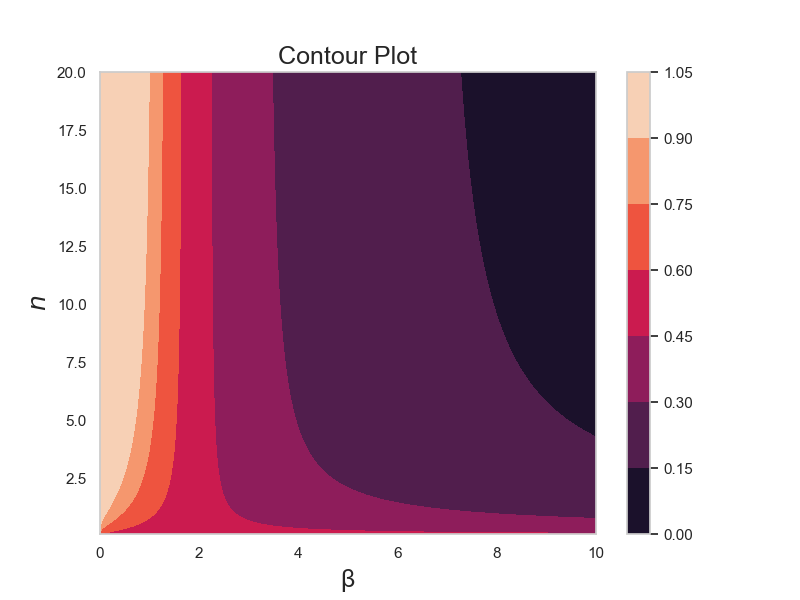

In [8]:
plt.close()

# Set up a figure with axes
fig, ax = plt.subplots(1, 1)

# Label the axes and title the plot
fig.set_size_inches(8, 6)

# Plot the contour lines
con_plt = ax.contourf(BETA, N, m)
fig.colorbar(con_plt, ax=ax)  # Add a colorbar to show the values
ax.title.set_text('Contour Plot');
ax.set_ylabel('$n$');
ax.set_xlabel(r'$\mathdefault{\beta}$');

In [87]:
filename = '/Volumes/James McGehee Mac/Documents/MATLAB_data/leslie_sna_HCR_quantification/averages_SEM.csv'
csvFile = pd.read_csv(filename)
arr_norm_sna = csvFile[['mean 2copy/sna1', 'SD 2copy/sna1', 'mean 1copy/sna1', 'SD 1copy/sna1']].to_numpy()
arr_norm_sna_1copy = csvFile['mean 1copy/sna1 1 copy'].to_numpy()
arr_ratio = csvFile['ratio 1copy/2copy'].to_numpy()
arr_2copy = csvFile['mean 2 copies'].to_numpy()
arr_1copy = csvFile['mean 1 copies'].to_numpy()

#filename = '/Volumes/James McGehee Mac/Documents/MATLAB_data/leslie_sna_HCR_quantification/averages_SEM_4_4.csv'
#csvFile = pd.read_csv(filename)
#arr_norm_4_4 = csvFile[['mean 2copy/4.4', 'SD 2copy/4.4', 'mean 1copy/4.4', 'SD 1copy/4.4']].to_numpy()

In [69]:
def root_fun(m, beta, n):
    return m - 1 / (1 + (beta * m)**n)

def _msolve(beta, n):
    return scipy.optimize.brentq(root_fun, 0, 1, args=(beta, n))

def msolve(beta, n):
    if np.isscalar(beta):
        if np.isscalar(n):
            result = _msolve(beta/2, n)/_msolve(beta, n)
        else:
            raise ValueError('beta and n must both be scalar or both be vector')
    else:
        if np.isscalar(n):
            raise ValueError('beta and n must both be scalar or both be vector')
        else:
            result = np.empty((len(n), len(beta)))
            for i, n_ in enumerate(n):
                for j, beta_ in enumerate(beta):
                    result[i, j] = _msolve(beta_/2, n_)/_msolve(beta_, n_)

    return result

In [95]:
beta0 = np.linspace(0, 20, 501)
n0 = np.linspace(0.1, 100, 500)
m0 = msolve(beta0, n0)

# Create data for the contour plot
BETA0, N0 = np.meshgrid(beta0, n0)

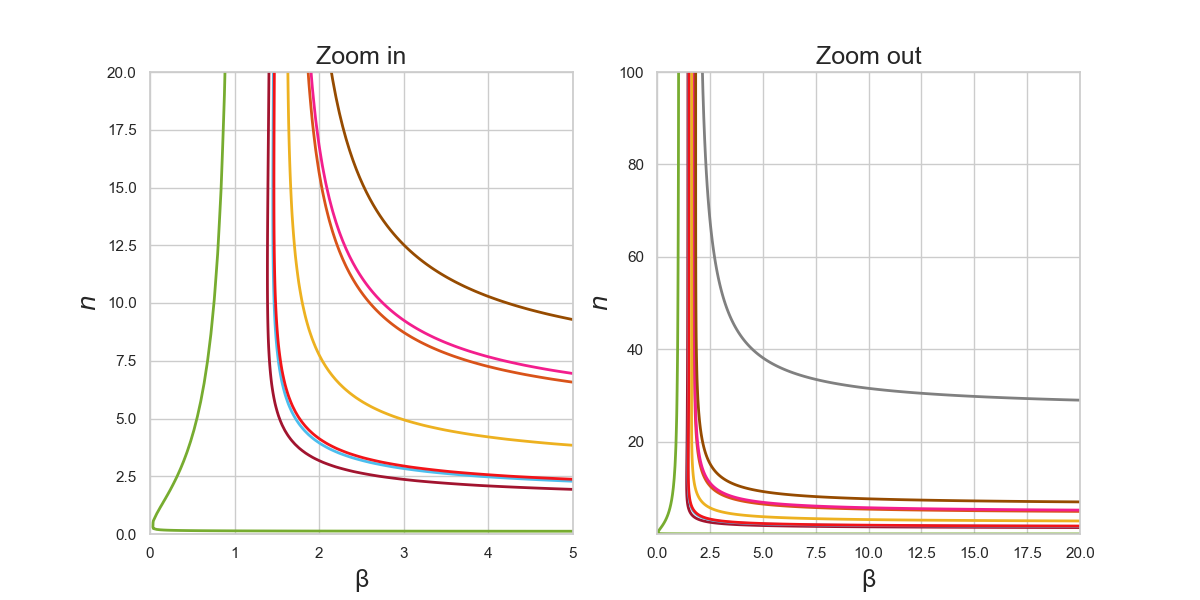

In [84]:
plt.close()
ind_lab = np.array([0, 5, 6, 7, 8, 9, 10, 1, 3, 11], dtype=int)

arr_ratio_nond = 2 * arr_1copy / arr_2copy
arr = np.sort(arr_ratio_nond)
sorted_indices = np.argsort(arr_ratio_nond)

# Set up a figure with axes
fig, ax = plt.subplots(1, 2)

# Label the axes and title the plot
fig.set_size_inches(12, 6)

# Plot the contour lines
con_plt0 = ax[0].contour(BETA0, N0, m0, levels=arr, colors=colors[ind_lab[sorted_indices]])
con_plt1 = ax[1].contour(BETA0, N0, m0, levels=arr, colors=colors[ind_lab[sorted_indices]])
ax[0].title.set_text('Zoom in');
ax[1].title.set_text('Zoom out');
ax[0].set_ylabel('$n$');
ax[0].set_xlabel(r'$\mathdefault{\beta}$');
ax[1].set_ylabel('$n$');
ax[1].set_xlabel(r'$\mathdefault{\beta}$');
ax[0].set_xlim([0,5]);
ax[0].set_ylim([0,20]);
#ax[1].set_xlim([0,10.0]);

In [86]:
filename = '/Volumes/James McGehee Mac/Documents/MATLAB_data/leslie_sna_HCR_quantification/averages_reverse_maternal.csv'
csvFile_rev = pd.read_csv(filename)
arr_2copy_rev = csvFile['mean 2 copies'].to_numpy()
arr_1copy_rev = csvFile['mean 1 copies'].to_numpy()

In [97]:
beta1 = np.linspace(0, 5, 501)
n1 = np.linspace(0.1, 20, 500)
m1 = msolve(beta1, n1)

# Create data for the contour plot
BETA1, N1 = np.meshgrid(beta1, n1)

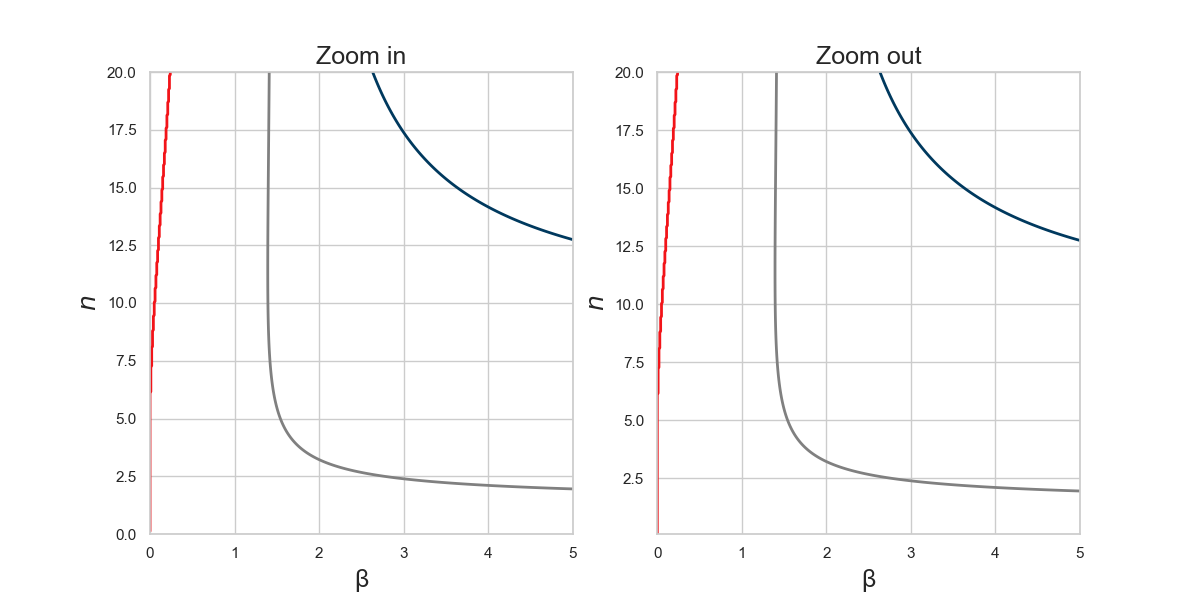

In [99]:
plt.close()

ind_lab = np.array([0, 8, 3], dtype=int)

arr_ratio_nond_rev = 2 * arr_1copy_rev / arr_2copy_rev
arr_ratio_nond_rev[1] = 1
arr = np.sort(arr_ratio_nond_rev)
sorted_indices = np.argsort(arr_ratio_nond_rev)

# Set up a figure with axes
fig, ax = plt.subplots(1, 2)

# Label the axes and title the plot
fig.set_size_inches(12, 6)

# Plot the contour lines
con_plt0 = ax[0].contour(BETA1, N1, m1, levels=arr, colors=colors[ind_lab[sorted_indices]])
con_plt1 = ax[1].contour(BETA1, N1, m1, levels=arr, colors=colors[ind_lab[sorted_indices]])
ax[0].title.set_text('Zoom in');
ax[1].title.set_text('Zoom out');
ax[0].set_ylabel('$n$');
ax[0].set_xlabel(r'$\mathdefault{\beta}$');
ax[1].set_ylabel('$n$');
ax[1].set_xlabel(r'$\mathdefault{\beta}$');
ax[0].set_xlim([0,5]);
ax[0].set_ylim([0,20]);
#ax[1].set_xlim([0,10.0]);

In [26]:
#@jit(nopython=True)
def root_fun_nond(m, beta, n, kappa):
    return m - ((1 / (1 + (beta * m)**n)) * (1 + ((beta * m)/((beta * m) + kappa))))
    #return m - ((1 / (1 + (beta * m)**n)) * (1 + ((beta * m)**n/((beta * m)**n + kappa**n))))

#@jit(nopython=True)
def _msolve_nond(beta, n, kappa):
    return scipy.optimize.brentq(root_fun_nond, 0, 2, args=(beta, n, kappa))

#@jit(nopython=True)
def msolve_nond(beta, n, kappa):
    if np.isscalar(beta):
        if np.isscalar(n):
            if np.isscalar(kappa):
                result = _msolve_nond(beta_/2, n_, kappa_)/_msolve_nond(beta, n, kappa)
            else:
                raise ValueError('beta and n must both be scalar or both be vector')
    else:
        if np.isscalar(n):
            raise ValueError('beta and n must both be scalar or both be vector')
        else:
            if np.isscalar(kappa):
                raise ValueError('beta and n must both be scalar or both be vector')
            else:
                result = np.empty((len(n), len(beta), len(kappa)))
                for i, n_ in enumerate(n):
                    for j, beta_ in enumerate(beta):
                        for k, kappa_ in enumerate(kappa):
                            result[i, j, k] = _msolve_nond(beta_/2, n_, kappa_)/_msolve_nond(beta_, n_, kappa_)

    return result

In [49]:
ind_lab = np.array([0, 5, 6, 7, 8, 9, 10, 1, 3, 11], dtype=int)

start_time = time.time()

n = np.linspace(1, 40, 100)
beta = np.linspace(0, 20, 101)
kappa = np.linspace(0.01, 2, 102)
m = msolve_nond(beta, n, kappa)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 75.49282693862915 seconds


In [50]:
# Create data for the contour plot
BETA0, N0 = np.meshgrid(beta, n)
KAPPA1, BETA1 = np.meshgrid(kappa, beta)
KAPPA2, N2 = np.meshgrid(kappa, n)

interactive(children=(IntSlider(value=0, description='n', max=49), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='k', max=51), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='b', max=50), Output()), _dom_classes=('widget-interact',…

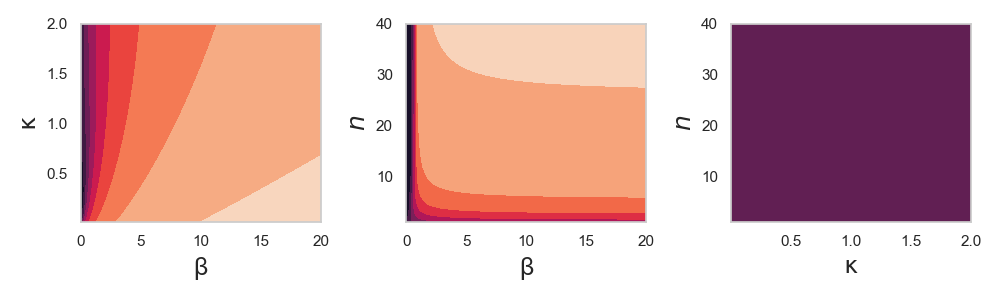

In [53]:
plt.close()

# Set up a figure with axes
fig, ax = plt.subplots(1, 3, label="")

# Label the axes and title the plot
fig.set_size_inches(10, 3)

# Remove the top right subplot
#ax[0,1].remove();

def update_plot_BK(i):
    # Plot the contour lines
    ax[0].clear()
    con_plt = ax[0].contourf(BETA1, KAPPA1, m[i,:,:])
    #fig.colorbar(con_plt, ax=ax[0,0])  # Add a colorbar to show the values
    #ax.title.set_text('Contour Plot');
    ax[0].set_ylabel(r'$\mathdefault{\kappa}$');
    ax[0].set_xlabel(r'$\mathdefault{\beta}$');
    fig.canvas.draw()

def update_plot_BN(k):
    # Plot the contour lines
    ax[1].clear()
    con_plt = ax[1].contourf(BETA0, N0, m[:,:,k])
    #fig.colorbar(con_plt, ax=ax[1,0])  # Add a colorbar to show the values
    #ax.title.set_text('Contour Plot');
    ax[1].set_ylabel('$n$');
    ax[1].set_xlabel(r'$\mathdefault{\beta}$');
    fig.canvas.draw()

def update_plot_KN(j):
    # Plot the contour lines
    ax[2].clear()
    con_plt = ax[2].contourf(KAPPA2, N2, m[:,j,:])
    #fig.colorbar(con_plt, ax=ax[1,1])  # Add a colorbar to show the values
    #ax.title.set_text('Contour Plot');
    ax[2].set_ylabel('$n$');
    ax[2].set_xlabel(r'$\mathdefault{\kappa}$');
    fig.canvas.draw()

update_plot_BK(0);
update_plot_BN(0);
update_plot_KN(0);

# Create the slider
n_slider = widgets.IntSlider(min=0, max=49, value=0, step=1, description='n');

# Use the interact function to connect the slider to the update_plot function
widgets.interact(update_plot_BK, i=n_slider);

# Create the slider
k_slider = widgets.IntSlider(min=0, max=51, value=0, step=1, description='k');

# Use the interact function to connect the slider to the update_plot function
widgets.interact(update_plot_BN, k=k_slider);

# Create the slider
b_slider = widgets.IntSlider(min=0, max=50, value=0, step=1, description='b');

# Use the interact function to connect the slider to the update_plot function
widgets.interact(update_plot_KN, j=b_slider);

plt.tight_layout()

interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='k', max=101), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=0, description='b'), Output()), _dom_classes=('widget-interact',))

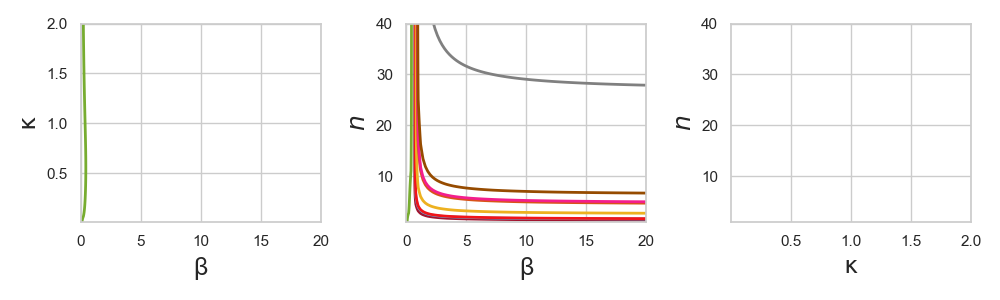

In [52]:
arr_ratio_nond = 2 * arr_1copy / arr_2copy

plt.close()

arr = np.sort(arr_ratio_nond)
sorted_indices = np.argsort(arr_ratio_nond)
#up_arr = np.sort(arr_norm_sna[:,0]+arr_norm_sna[:,1])
#up_sorted = np.argsort(arr_norm_sna[:,0]+arr_norm_sna[:,1])
#down_arr = np.sort(arr_norm_sna[:,0]-arr_norm_sna[:,1])
#down_sorted = np.argsort(arr_norm_sna[:,0]-arr_norm_sna[:,1])

# Set up a figure with axes
fig1, ax1 = plt.subplots(1, 3, label="")

# Label the axes and title the plot
fig1.set_size_inches(10, 3)

# Remove the top right subplot
#ax[0,1].remove();

def update_cont_BK(i):
    # Plot the contour lines
    ax1[0].clear()
    con_plt1 = ax1[0].contour(BETA1, KAPPA1, m[i,:,:], levels=arr, colors=colors[ind_lab[sorted_indices]])
    #fig.colorbar(con_plt, ax=ax[0,0])  # Add a colorbar to show the values
    #ax.title.set_text('Contour Plot');
    ax1[0].set_ylabel(r'$\mathdefault{\kappa}$');
    ax1[0].set_xlabel(r'$\mathdefault{\beta}$');
    fig1.canvas.draw()

def update_cont_BN(k):
    # Plot the contour lines
    ax1[1].clear()
    con_plt1 = ax1[1].contour(BETA0, N0, m[:,:,k], levels=arr, colors=colors[ind_lab[sorted_indices]])
    #fig.colorbar(con_plt, ax=ax[1,0])  # Add a colorbar to show the values
    #ax.title.set_text('Contour Plot');
    ax1[1].set_ylabel('$n$');
    ax1[1].set_xlabel(r'$\mathdefault{\beta}$');
    fig1.canvas.draw()

def update_cont_KN(j):
    # Plot the contour lines
    ax1[2].clear()
    con_plt1 = ax1[2].contour(KAPPA2, N2, m[:,j,:], levels=arr, colors=colors[ind_lab[sorted_indices]])
    #fig.colorbar(con_plt, ax=ax[1,1])  # Add a colorbar to show the values
    #ax.title.set_text('Contour Plot');
    ax1[2].set_ylabel('$n$');
    ax1[2].set_xlabel(r'$\mathdefault{\kappa}$');
    fig1.canvas.draw()

update_cont_BK(0);
update_cont_BN(0);
update_cont_KN(0);

# Create the slider
n_slider_cont = widgets.IntSlider(min=0, max=99, value=0, step=1, description='n');

# Use the interact function to connect the slider to the update_plot function
widgets.interact(update_cont_BK, i=n_slider_cont);

# Create the slider
k_slider_cont = widgets.IntSlider(min=0, max=101, value=0, step=1, description='k');

# Use the interact function to connect the slider to the update_plot function
widgets.interact(update_cont_BN, k=k_slider_cont);

# Create the slider
b_slider_cont = widgets.IntSlider(min=0, max=100, value=0, step=1, description='b');

# Use the interact function to connect the slider to the update_plot function
widgets.interact(update_cont_KN, j=b_slider_cont);

plt.tight_layout()